In [4]:
import scipy.io, math, os
import os
import pandas as pd, numpy as np
from help_functions import *

import matplotlib.pyplot as plt
import matplotlib.animation as FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

In [47]:
directory = 'data/Data/F1/mat'
counter = 1
UL_df, LL_df, JW_df, TD_df, TB_df, TT_df, audio_df = [], [], [], [], [], [], []

# Go through all the ema files and append a list so each file is found in one place
for filename in sorted(os.listdir(directory)):
    if filename.endswith('.mat'):
        f = os.path.join(directory, filename)
        mat = scipy.io.loadmat(f)
        # takes the data that is stored at the key that precedes the data for each .mat file
        data = mat['usctimit_ema_f1_{:03}_{:03}'.format(counter, counter + 4)]
        counter += 5

        # make dataframes of the six positions
        audio_df.append(pd.DataFrame.from_dict(data[0][0][2]))
        UL_df.append(pd.DataFrame.from_dict(data[0][1][2]))
        LL_df.append(pd.DataFrame.from_dict(data[0][2][2]))
        JW_df.append(pd.DataFrame.from_dict(data[0][3][2]))
        TD_df.append(pd.DataFrame.from_dict(data[0][4][2]))
        TB_df.append(pd.DataFrame.from_dict(data[0][5][2]))
        TT_df.append(pd.DataFrame.from_dict(data[0][6][2]))

# add file code to each dataframe
add_file(UL_df)
add_file(LL_df)
add_file(JW_df)
add_file(TD_df)
add_file(TB_df)
add_file(TT_df)

# merge the list into dataframe 
merged_ul = pd.concat(UL_df, axis = 0)
merged_ll = pd.concat(LL_df, axis = 0)
merged_jw = pd.concat(JW_df, axis = 0)
merged_td = pd.concat(TD_df, axis = 0)
merged_tb = pd.concat(TB_df, axis = 0)
merged_tt = pd.concat(TT_df, axis = 0)

# rename the columns
merged_ul.columns = ['File Code', 'ul_0', 'ul_1', 'ul_2']
merged_ll.columns = ['File Code','ll_0', 'll_1', 'll_2']
merged_jw.columns = ['File Code','jw_0', 'jw_1', 'jw_2']
merged_td.columns = ['File Code','td_0', 'td_1', 'td_2']
merged_tb.columns = ['File Code','tb_0', 'tb_1', 'tb_2']
merged_tt.columns = ['File Code','tt_0', 'tt_1', 'tt_2']

In [10]:
ema_frames = list()

with open('timestamps.txt', 'r') as file:
    timestamps = file.read().splitlines()
    for line in timestamps:
        split_line = line.split(',')
        sent_number = int(split_line[-1])
        file_code = int(split_line[0])
       
        # find start and end by multiplying the timestamps with the sampling rate for ema markers
        starting_point = math.floor(float(split_line[2]) * get_srate(int(split_line[0])))
        ending_point = math.ceil(float(split_line[3]) * get_srate(int(split_line[0])))
        
        # find start and end by multiplying the timestamps with the sampling rate for audio
        start_point = (math.floor(float(split_line[2]) * 22050)) - 220
        end_point = (math.ceil(float(split_line[3]) * 22050)) + 220
             
        # get data frame with all values for ema marker
        ul = get_values(UL_df, merged_ul, file_code)
        ll = get_values(LL_df, merged_ll, file_code)
        jw = get_values(JW_df, merged_jw, file_code)
        td = get_values(TD_df, merged_td, file_code)
        tb = get_values(TB_df, merged_tb, file_code)
        tt = get_values(TT_df, merged_tt, file_code)
        
        # concate all dataframes with ema markers
        df_data = pd.concat([ul, ll, jw, td, tb, tt], axis = 1)
        df_data = df_data.loc[:,~df_data.columns.duplicated()]
        
        # get matching audio segment
        for i in range(len(audio_df)):
            if (file_code == i):
                current_df = audio_df[i]
                segment = current_df.iloc[starting_point:end_point, :]
            break 

        
        # retrieve meta data and combine with ema data into dictionary
        data = {'word' : [split_line[1]],
                'srate': [get_srate(int(split_line[0]))],
                'sent' : [sent_number],
                'file' : [file_code],
                'Data'   : [df_data],
                'Audio' : [segment]} 
        
        ema_frames.append(data)

In [11]:
audio_frames = list()

with open('timestamps.txt', 'r') as file:
    timestamps = file.read().splitlines()
    for line in timestamps:
        split_line = line.split(',')
        sent_number = int(split_line[-1])
        file_code = int(split_line[0])
        
        # find start and end by multiplying the timestamps with the sampling rate
        starting_point = (math.floor(float(split_line[2]) * 22050)) - 220
        end_point = (math.ceil(float(split_line[3]) * 22050)) + 220
        
          
            
        data = {'word' : [split_line[1]],
                'srate': [get_srate(int(split_line[0]))],
                'sent' : [int(split_line[-1])],
                'file' : [file_code],
                'Audio'   : [segment]} 
        
        audio_frames.append(data)

In [9]:
# FUNCTIONING FOR ADDING FILE CODE
def add_file(dataframe): 
    ''' 
        Using the list, get the index as the file code and add a new column with this index information
    '''
    for idx, frame in enumerate(dataframe):
        frame['File code'] = idx
        first_column = frame.pop('File code')
        frame.insert(0, 'File code', first_column)
        

# FUNCTION FOR OBTAINING SAMPLING RATE
def get_srate(file_number):
    '''
        From the ema files get the sampling rate
    ''' 
    directory = 'data/Data/F1/mat'
    
    # still needs to ignore the .DS_Store file in a better way
    file = sorted(os.listdir(directory))[file_number + 1]
    
    f = os.path.join(directory, file)
    mat = scipy.io.loadmat(f)['usctimit_ema_f1_{:03}_{:03}'.format(file_number*5 + 1, file_number*5 + 5)]
    
    #returns the srate which is stored here
    return mat[0][1][1][0][0]


# FUNCTION FOR GETTING COORIDNATES FOR WORD TIMEFRAME
def get_values(df_list, merged_df, file_code): 
    '''
        Goes through list of dataframe and if it matches the file code it gets the coordinates for th
    '''
    for i in range(len(df_list)):
        if (file_code == i):
            current_df = merged_df.loc[merged_df['File Code'] == i]
            current_var = current_df.iloc[starting_point:ending_point, :]
            
    return current_var

Total data frames =  3435
Shape of Audio for first word =  362470


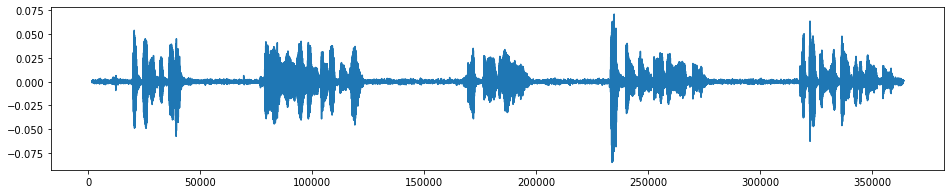

In [33]:
print("Total data frames = ", len(audio_frames))
print("Shape of Audio for first word = ", len(audio_frames[0]['Audio'][0]))

# plot wave by audio frame of first word
plt.figure(figsize=(16, 3))
plt.plot(audio_frames[0]['Audio'][0], '-', );

In [51]:
os.getcwd()

'C:\\Users\\nchau\\Documents\\Work\\Nick Ramsey\\Code\\UMC'

<ipython-input-82-2e2792b36915>:7: FutureWarning: Pass y=[-0.00042725 -0.00027466 -0.00018311 ...  0.00292969  0.00317383
  0.00320435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  dur=librosa.get_duration(signal)


duration: 18.404580498866213
(405821,) 22050


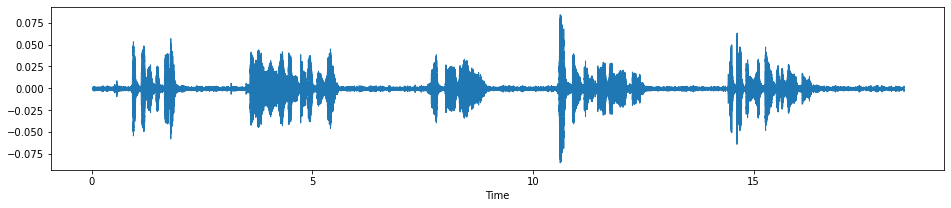

In [82]:
import librosa, librosa.display

normal_file = "/data/Data/F1/wav/usctimit_ema_f1_001_005.wav"
normal_file

signal, sr = librosa.load(r'data\Data\F1\wav\usctimit_ema_f1_001_005.wav')
dur=librosa.get_duration(signal)
print ("duration:", dur)
# The sample rate (sr) by default is 22050, which means that for every second there are 22,050 samples
print(signal.shape, sr)

# librosa plot
plt.figure(figsize=(16, 3))
librosa.display.waveshow(signal, sr=sr)

In [63]:
# hear the wav file
import IPython.display as ipd
ipd.Audio(signal, rate=sr)

In [72]:
# ask about parameters

n_fft = 2048
hop_length = 512

mel_signal = librosa.feature.melspectrogram(y=signal, sr=sr, hop_length=hop_length, 
 n_fft=n_fft)
spectrogram = np.abs(mel_signal)
power_to_db = librosa.power_to_db(spectrogram, ref=np.max)
plt.figure(figsize=(8, 7))
librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel', cmap='magma', 
 hop_length=hop_length)
plt.colorbar(label='dB')
plt.title('Mel-Spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

SyntaxError: invalid syntax (<ipython-input-72-59764c097ecb>, line 6)

<ipython-input-83-ef260700d50b>:3: FutureWarning: Pass size=410821 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y = librosa.util.fix_length(signal, input_length)


(410821,)


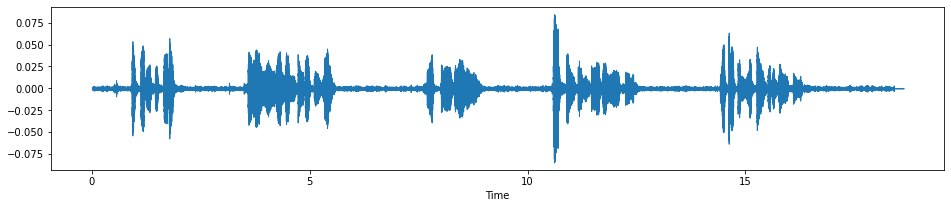

In [83]:
# add padding if duration of wav is shorter then threshold then add padding to file

input_length = 405821 + 5000
if(round(dur) < 20): # arbritary number
    y = librosa.util.fix_length(signal, input_length) 
print(y.shape)
plt.figure(figsize=(16, 3))
librosa.display.waveshow(y, sr=sr)

In [96]:
main_window = audio_frames[0]['Audio'][0]
length_array = len(main_window) 
print("Length of array is: ", len(main_window)) # 362470
window_size = round(len(main_window)//1000)
print("Length of window size is: ", window_size) # 362

sub_windows = list()

for i in range(length_array + 1):
    print(i)
    end_window = (i+window_size)
    sub = main_window[i:end_window]
    sub_windows.append(sub)

Length of array is:  362470
Length of window size is:  362
0
             0
1575 -0.000305
1576 -0.000305
1577 -0.000458
1578 -0.000580
1579 -0.000549
...        ...
1932  0.001129
1933  0.001068
1934  0.001221
1935  0.001221
1936  0.001343

[362 rows x 1 columns]
1
             0
1576 -0.000305
1577 -0.000458
1578 -0.000580
1579 -0.000549
1580 -0.000549
...        ...
1933  0.001068
1934  0.001221
1935  0.001221
1936  0.001343
1937  0.001434

[362 rows x 1 columns]
2
             0
1577 -0.000458
1578 -0.000580
1579 -0.000549
1580 -0.000549
1581 -0.000488
...        ...
1934  0.001221
1935  0.001221
1936  0.001343
1937  0.001434
1938  0.001343

[362 rows x 1 columns]
3
             0
1578 -0.000580
1579 -0.000549
1580 -0.000549
1581 -0.000488
1582 -0.000458
...        ...
1935  0.001221
1936  0.001343
1937  0.001434
1938  0.001343
1939  0.001251

[362 rows x 1 columns]
4
             0
1579 -0.000549
1580 -0.000549
1581 -0.000488
1582 -0.000458
1583 -0.000458
...        ...
1936  0.00

[362 rows x 1 columns]
54
             0
1629 -0.000763
1630 -0.000763
1631 -0.000793
1632 -0.000793
1633 -0.000824
...        ...
1986  0.000183
1987  0.000153
1988  0.000122
1989  0.000214
1990  0.000336

[362 rows x 1 columns]
55
             0
1630 -0.000763
1631 -0.000793
1632 -0.000793
1633 -0.000824
1634 -0.000946
...        ...
1987  0.000153
1988  0.000122
1989  0.000214
1990  0.000336
1991  0.000458

[362 rows x 1 columns]
56
             0
1631 -0.000793
1632 -0.000793
1633 -0.000824
1634 -0.000946
1635 -0.001007
...        ...
1988  0.000122
1989  0.000214
1990  0.000336
1991  0.000458
1992  0.000641

[362 rows x 1 columns]
57
             0
1632 -0.000793
1633 -0.000824
1634 -0.000946
1635 -0.001007
1636 -0.000854
...        ...
1989  0.000214
1990  0.000336
1991  0.000458
1992  0.000641
1993  0.000549

[362 rows x 1 columns]
58
             0
1633 -0.000824
1634 -0.000946
1635 -0.001007
1636 -0.000854
1637 -0.000824
...        ...
1990  0.000336
1991  0.000458
1992  0.000

[362 rows x 1 columns]
112
             0
1687  0.000366
1688  0.000336
1689  0.000366
1690  0.000397
1691  0.000488
...        ...
2044  0.001190
2045  0.001373
2046  0.001465
2047  0.001404
2048  0.001343

[362 rows x 1 columns]
113
             0
1688  0.000336
1689  0.000366
1690  0.000397
1691  0.000488
1692  0.000580
...        ...
2045  0.001373
2046  0.001465
2047  0.001404
2048  0.001343
2049  0.001434

[362 rows x 1 columns]
114
             0
1689  0.000366
1690  0.000397
1691  0.000488
1692  0.000580
1693  0.000641
...        ...
2046  0.001465
2047  0.001404
2048  0.001343
2049  0.001434
2050  0.001587

[362 rows x 1 columns]
115
             0
1690  0.000397
1691  0.000488
1692  0.000580
1693  0.000641
1694  0.000641
...        ...
2047  0.001404
2048  0.001343
2049  0.001434
2050  0.001587
2051  0.001648

[362 rows x 1 columns]
116
             0
1691  0.000488
1692  0.000580
1693  0.000641
1694  0.000641
1695  0.000610
...        ...
2048  0.001343
2049  0.001434
2050  

[362 rows x 1 columns]
180
             0
1755 -0.000031
1756  0.000061
1757  0.000153
1758  0.000031
1759 -0.000122
...        ...
2112 -0.000336
2113 -0.000427
2114 -0.000580
2115 -0.000458
2116 -0.000458

[362 rows x 1 columns]
181
             0
1756  0.000061
1757  0.000153
1758  0.000031
1759 -0.000122
1760 -0.000244
...        ...
2113 -0.000427
2114 -0.000580
2115 -0.000458
2116 -0.000458
2117 -0.000397

[362 rows x 1 columns]
182
             0
1757  0.000153
1758  0.000031
1759 -0.000122
1760 -0.000244
1761 -0.000275
...        ...
2114 -0.000580
2115 -0.000458
2116 -0.000458
2117 -0.000397
2118 -0.000580

[362 rows x 1 columns]
183
             0
1758  0.000031
1759 -0.000122
1760 -0.000244
1761 -0.000275
1762 -0.000244
...        ...
2115 -0.000458
2116 -0.000458
2117 -0.000397
2118 -0.000580
2119 -0.000580

[362 rows x 1 columns]
184
             0
1759 -0.000122
1760 -0.000244
1761 -0.000275
1762 -0.000244
1763 -0.000244
...        ...
2116 -0.000458
2117 -0.000397
2118 -

             0
1831  0.000275
1832  0.000244
1833  0.000305
1834  0.000488
1835  0.000671
...        ...
2188 -0.000458
2189 -0.000641
2190 -0.000793
2191 -0.000702
2192 -0.000702

[362 rows x 1 columns]
257
             0
1832  0.000244
1833  0.000305
1834  0.000488
1835  0.000671
1836  0.000702
...        ...
2189 -0.000641
2190 -0.000793
2191 -0.000702
2192 -0.000702
2193 -0.000397

[362 rows x 1 columns]
258
             0
1833  0.000305
1834  0.000488
1835  0.000671
1836  0.000702
1837  0.000610
...        ...
2190 -0.000793
2191 -0.000702
2192 -0.000702
2193 -0.000397
2194 -0.000244

[362 rows x 1 columns]
259
             0
1834  0.000488
1835  0.000671
1836  0.000702
1837  0.000610
1838  0.000549
...        ...
2191 -0.000702
2192 -0.000702
2193 -0.000397
2194 -0.000244
2195 -0.000214

[362 rows x 1 columns]
260
             0
1835  0.000671
1836  0.000702
1837  0.000610
1838  0.000549
1839  0.000519
...        ...
2192 -0.000702
2193 -0.000397
2194 -0.000244
2195 -0.000214
219

[362 rows x 1 columns]
317
             0
1892  0.000702
1893  0.000793
1894  0.000763
1895  0.000824
1896  0.000793
...        ...
2249  0.000092
2250  0.000122
2251 -0.000061
2252 -0.000214
2253 -0.000305

[362 rows x 1 columns]
318
             0
1893  0.000793
1894  0.000763
1895  0.000824
1896  0.000793
1897  0.000854
...        ...
2250  0.000122
2251 -0.000061
2252 -0.000214
2253 -0.000305
2254 -0.000366

[362 rows x 1 columns]
319
             0
1894  0.000763
1895  0.000824
1896  0.000793
1897  0.000854
1898  0.001068
...        ...
2251 -0.000061
2252 -0.000214
2253 -0.000305
2254 -0.000366
2255 -0.000275

[362 rows x 1 columns]
320
             0
1895  0.000824
1896  0.000793
1897  0.000854
1898  0.001068
1899  0.001038
...        ...
2252 -0.000214
2253 -0.000305
2254 -0.000366
2255 -0.000275
2256 -0.000214

[362 rows x 1 columns]
321
             0
1896  0.000793
1897  0.000854
1898  0.001068
1899  0.001038
1900  0.000977
...        ...
2253 -0.000305
2254 -0.000366
2255 -

             0
1959  0.000610
1960  0.000732
1961  0.000732
1962  0.000763
1963  0.000824
...        ...
2316  0.001373
2317  0.001404
2318  0.001465
2319  0.001587
2320  0.001404

[362 rows x 1 columns]
385
             0
1960  0.000732
1961  0.000732
1962  0.000763
1963  0.000824
1964  0.000793
...        ...
2317  0.001404
2318  0.001465
2319  0.001587
2320  0.001404
2321  0.001373

[362 rows x 1 columns]
386
             0
1961  0.000732
1962  0.000763
1963  0.000824
1964  0.000793
1965  0.000763
...        ...
2318  0.001465
2319  0.001587
2320  0.001404
2321  0.001373
2322  0.001282

[362 rows x 1 columns]
387
             0
1962  0.000763
1963  0.000824
1964  0.000793
1965  0.000763
1966  0.000793
...        ...
2319  0.001587
2320  0.001404
2321  0.001373
2322  0.001282
2323  0.001160

[362 rows x 1 columns]
388
             0
1963  0.000824
1964  0.000793
1965  0.000763
1966  0.000793
1967  0.000763
...        ...
2320  0.001404
2321  0.001373
2322  0.001282
2323  0.001160
232

[362 rows x 1 columns]
459
             0
2034  0.001068
2035  0.001068
2036  0.001129
2037  0.001129
2038  0.001221
...        ...
2391 -0.000610
2392 -0.000671
2393 -0.000641
2394 -0.000702
2395 -0.000732

[362 rows x 1 columns]
460
             0
2035  0.001068
2036  0.001129
2037  0.001129
2038  0.001221
2039  0.001251
...        ...
2392 -0.000671
2393 -0.000641
2394 -0.000702
2395 -0.000732
2396 -0.000824

[362 rows x 1 columns]
461
             0
2036  0.001129
2037  0.001129
2038  0.001221
2039  0.001251
2040  0.001160
...        ...
2393 -0.000641
2394 -0.000702
2395 -0.000732
2396 -0.000824
2397 -0.000610

[362 rows x 1 columns]
462
             0
2037  0.001129
2038  0.001221
2039  0.001251
2040  0.001160
2041  0.001099
...        ...
2394 -0.000702
2395 -0.000732
2396 -0.000824
2397 -0.000610
2398 -0.000488

[362 rows x 1 columns]
463
             0
2038  0.001221
2039  0.001251
2040  0.001160
2041  0.001099
2042  0.000946
...        ...
2395 -0.000732
2396 -0.000824
2397 -

[362 rows x 1 columns]
523
             0
2098  0.000641
2099  0.000641
2100  0.000519
2101  0.000519
2102  0.000427
...        ...
2455  0.000214
2456  0.000122
2457  0.000061
2458 -0.000031
2459 -0.000061

[362 rows x 1 columns]
524
             0
2099  0.000641
2100  0.000519
2101  0.000519
2102  0.000427
2103  0.000336
...        ...
2456  0.000122
2457  0.000061
2458 -0.000031
2459 -0.000061
2460  0.000183

[362 rows x 1 columns]
525
             0
2100  0.000519
2101  0.000519
2102  0.000427
2103  0.000336
2104  0.000336
...        ...
2457  0.000061
2458 -0.000031
2459 -0.000061
2460  0.000183
2461  0.000244

[362 rows x 1 columns]
526
             0
2101  0.000519
2102  0.000427
2103  0.000336
2104  0.000336
2105  0.000244
...        ...
2458 -0.000031
2459 -0.000061
2460  0.000183
2461  0.000244
2462  0.000183

[362 rows x 1 columns]
527
             0
2102  0.000427
2103  0.000336
2104  0.000336
2105  0.000244
2106  0.000153
...        ...
2459 -0.000061
2460  0.000183
2461  

             0
2168 -0.000610
2169 -0.000641
2170 -0.000610
2171 -0.000641
2172 -0.000793
...        ...
2525 -0.000427
2526 -0.000427
2527 -0.000366
2528 -0.000336
2529 -0.000366

[362 rows x 1 columns]
594
             0
2169 -0.000641
2170 -0.000610
2171 -0.000641
2172 -0.000793
2173 -0.000763
...        ...
2526 -0.000427
2527 -0.000366
2528 -0.000336
2529 -0.000366
2530 -0.000214

[362 rows x 1 columns]
595
             0
2170 -0.000610
2171 -0.000641
2172 -0.000793
2173 -0.000763
2174 -0.000824
...        ...
2527 -0.000366
2528 -0.000336
2529 -0.000366
2530 -0.000214
2531 -0.000244

[362 rows x 1 columns]
596
             0
2171 -0.000641
2172 -0.000793
2173 -0.000763
2174 -0.000824
2175 -0.000916
...        ...
2528 -0.000336
2529 -0.000366
2530 -0.000214
2531 -0.000244
2532 -0.000305

[362 rows x 1 columns]
597
             0
2172 -0.000793
2173 -0.000763
2174 -0.000824
2175 -0.000916
2176 -0.000824
...        ...
2529 -0.000366
2530 -0.000214
2531 -0.000244
2532 -0.000305
253

             0
2238 -0.000122
2239 -0.000061
2240  0.000092
2241  0.000275
2242  0.000275
...        ...
2595  0.000366
2596  0.000244
2597  0.000244
2598  0.000397
2599  0.000488

[362 rows x 1 columns]
664
             0
2239 -0.000061
2240  0.000092
2241  0.000275
2242  0.000275
2243  0.000153
...        ...
2596  0.000244
2597  0.000244
2598  0.000397
2599  0.000488
2600  0.000519

[362 rows x 1 columns]
665
             0
2240  0.000092
2241  0.000275
2242  0.000275
2243  0.000153
2244  0.000153
...        ...
2597  0.000244
2598  0.000397
2599  0.000488
2600  0.000519
2601  0.000519

[362 rows x 1 columns]
666
             0
2241  0.000275
2242  0.000275
2243  0.000153
2244  0.000153
2245  0.000061
...        ...
2598  0.000397
2599  0.000488
2600  0.000519
2601  0.000519
2602  0.000702

[362 rows x 1 columns]
667
             0
2242  0.000275
2243  0.000153
2244  0.000153
2245  0.000061
2246  0.000061
...        ...
2599  0.000488
2600  0.000519
2601  0.000519
2602  0.000702
260

[362 rows x 1 columns]
730
             0
2305  0.001007
2306  0.001068
2307  0.001068
2308  0.001099
2309  0.001221
...        ...
2662 -0.000458
2663 -0.000366
2664 -0.000275
2665 -0.000366
2666 -0.000519

[362 rows x 1 columns]
731
             0
2306  0.001068
2307  0.001068
2308  0.001099
2309  0.001221
2310  0.001282
...        ...
2663 -0.000366
2664 -0.000275
2665 -0.000366
2666 -0.000519
2667 -0.000549

[362 rows x 1 columns]
732
             0
2307  0.001068
2308  0.001099
2309  0.001221
2310  0.001282
2311  0.001373
...        ...
2664 -0.000275
2665 -0.000366
2666 -0.000519
2667 -0.000549
2668 -0.000641

[362 rows x 1 columns]
733
             0
2308  0.001099
2309  0.001221
2310  0.001282
2311  0.001373
2312  0.001404
...        ...
2665 -0.000366
2666 -0.000519
2667 -0.000549
2668 -0.000641
2669 -0.000671

[362 rows x 1 columns]
734
             0
2309  0.001221
2310  0.001282
2311  0.001373
2312  0.001404
2313  0.001434
...        ...
2666 -0.000519
2667 -0.000549
2668 -

             0
2372 -0.000458
2373 -0.000458
2374 -0.000336
2375 -0.000244
2376 -0.000366
...        ...
2729 -0.001251
2730 -0.001404
2731 -0.001373
2732 -0.001373
2733 -0.001190

[362 rows x 1 columns]
798
             0
2373 -0.000458
2374 -0.000336
2375 -0.000244
2376 -0.000366
2377 -0.000458
...        ...
2730 -0.001404
2731 -0.001373
2732 -0.001373
2733 -0.001190
2734 -0.001038

[362 rows x 1 columns]
799
             0
2374 -0.000336
2375 -0.000244
2376 -0.000366
2377 -0.000458
2378 -0.000519
...        ...
2731 -0.001373
2732 -0.001373
2733 -0.001190
2734 -0.001038
2735 -0.001068

[362 rows x 1 columns]
800
             0
2375 -0.000244
2376 -0.000366
2377 -0.000458
2378 -0.000519
2379 -0.000549
...        ...
2732 -0.001373
2733 -0.001190
2734 -0.001038
2735 -0.001068
2736 -0.001160

[362 rows x 1 columns]
801
             0
2376 -0.000366
2377 -0.000458
2378 -0.000519
2379 -0.000549
2380 -0.000641
...        ...
2733 -0.001190
2734 -0.001038
2735 -0.001068
2736 -0.001160
273

[362 rows x 1 columns]
863
             0
2438  0.000336
2439  0.000244
2440  0.000000
2441  0.000000
2442 -0.000061
...        ...
2795 -0.001373
2796 -0.001434
2797 -0.001373
2798 -0.001526
2799 -0.001434

[362 rows x 1 columns]
864
             0
2439  0.000244
2440  0.000000
2441  0.000000
2442 -0.000061
2443  0.000031
...        ...
2796 -0.001434
2797 -0.001373
2798 -0.001526
2799 -0.001434
2800 -0.001526

[362 rows x 1 columns]
865
             0
2440  0.000000
2441  0.000000
2442 -0.000061
2443  0.000031
2444  0.000000
...        ...
2797 -0.001373
2798 -0.001526
2799 -0.001434
2800 -0.001526
2801 -0.001587

[362 rows x 1 columns]
866
             0
2441  0.000000
2442 -0.000061
2443  0.000031
2444  0.000000
2445 -0.000061
...        ...
2798 -0.001526
2799 -0.001434
2800 -0.001526
2801 -0.001587
2802 -0.001526

[362 rows x 1 columns]
867
             0
2442 -0.000061
2443  0.000031
2444  0.000000
2445 -0.000061
2446  0.000000
...        ...
2799 -0.001434
2800 -0.001526
2801 -

             0
2505 -0.000275
2506 -0.000092
2507  0.000000
2508 -0.000031
2509 -0.000061
...        ...
2862 -0.000732
2863 -0.000763
2864 -0.000702
2865 -0.000580
2866 -0.000458

[362 rows x 1 columns]
931
             0
2506 -0.000092
2507  0.000000
2508 -0.000031
2509 -0.000061
2510 -0.000122
...        ...
2863 -0.000763
2864 -0.000702
2865 -0.000580
2866 -0.000458
2867 -0.000336

[362 rows x 1 columns]
932
             0
2507  0.000000
2508 -0.000031
2509 -0.000061
2510 -0.000122
2511 -0.000366
...        ...
2864 -0.000702
2865 -0.000580
2866 -0.000458
2867 -0.000336
2868 -0.000397

[362 rows x 1 columns]
933
             0
2508 -0.000031
2509 -0.000061
2510 -0.000122
2511 -0.000366
2512 -0.000427
...        ...
2865 -0.000580
2866 -0.000458
2867 -0.000336
2868 -0.000397
2869 -0.000305

[362 rows x 1 columns]
934
             0
2509 -0.000061
2510 -0.000122
2511 -0.000366
2512 -0.000427
2513 -0.000397
...        ...
2866 -0.000458
2867 -0.000336
2868 -0.000397
2869 -0.000305
287

[362 rows x 1 columns]
1003
             0
2578  0.000916
2579  0.000702
2580  0.000580
2581  0.000427
2582  0.000305
...        ...
2935  0.001007
2936  0.001068
2937  0.001160
2938  0.001190
2939  0.001251

[362 rows x 1 columns]
1004
             0
2579  0.000702
2580  0.000580
2581  0.000427
2582  0.000305
2583  0.000275
...        ...
2936  0.001068
2937  0.001160
2938  0.001190
2939  0.001251
2940  0.001129

[362 rows x 1 columns]
1005
             0
2580  0.000580
2581  0.000427
2582  0.000305
2583  0.000275
2584  0.000275
...        ...
2937  0.001160
2938  0.001190
2939  0.001251
2940  0.001129
2941  0.001129

[362 rows x 1 columns]
1006
             0
2581  0.000427
2582  0.000305
2583  0.000275
2584  0.000275
2585  0.000397
...        ...
2938  0.001190
2939  0.001251
2940  0.001129
2941  0.001129
2942  0.001099

[362 rows x 1 columns]
1007
             0
2582  0.000305
2583  0.000275
2584  0.000275
2585  0.000397
2586  0.000427
...        ...
2939  0.001251
2940  0.001129
2

             0
2640  0.000427
2641  0.000305
2642  0.000275
2643  0.000366
2644  0.000244
...        ...
2997  0.000397
2998  0.000427
2999  0.000458
3000  0.000671
3001  0.000671

[362 rows x 1 columns]
1066
             0
2641  0.000305
2642  0.000275
2643  0.000366
2644  0.000244
2645  0.000214
...        ...
2998  0.000427
2999  0.000458
3000  0.000671
3001  0.000671
3002  0.000610

[362 rows x 1 columns]
1067
             0
2642  0.000275
2643  0.000366
2644  0.000244
2645  0.000214
2646  0.000244
...        ...
2999  0.000458
3000  0.000671
3001  0.000671
3002  0.000610
3003  0.000458

[362 rows x 1 columns]
1068
             0
2643  0.000366
2644  0.000244
2645  0.000214
2646  0.000244
2647  0.000244
...        ...
3000  0.000671
3001  0.000671
3002  0.000610
3003  0.000458
3004  0.000427

[362 rows x 1 columns]
1069
             0
2644  0.000244
2645  0.000214
2646  0.000244
2647  0.000244
2648  0.000336
...        ...
3001  0.000671
3002  0.000610
3003  0.000458
3004  0.000427

             0
2706 -0.001678
2707 -0.001740
2708 -0.001709
2709 -0.001678
2710 -0.001587
...        ...
3063  0.001190
3064  0.001282
3065  0.001312
3066  0.001221
3067  0.001251

[362 rows x 1 columns]
1132
             0
2707 -0.001740
2708 -0.001709
2709 -0.001678
2710 -0.001587
2711 -0.001495
...        ...
3064  0.001282
3065  0.001312
3066  0.001221
3067  0.001251
3068  0.001312

[362 rows x 1 columns]
1133
             0
2708 -0.001709
2709 -0.001678
2710 -0.001587
2711 -0.001495
2712 -0.001465
...        ...
3065  0.001312
3066  0.001221
3067  0.001251
3068  0.001312
3069  0.001343

[362 rows x 1 columns]
1134
             0
2709 -0.001678
2710 -0.001587
2711 -0.001495
2712 -0.001465
2713 -0.001434
...        ...
3066  0.001221
3067  0.001251
3068  0.001312
3069  0.001343
3070  0.001373

[362 rows x 1 columns]
1135
             0
2710 -0.001587
2711 -0.001495
2712 -0.001465
2713 -0.001434
2714 -0.001465
...        ...
3067  0.001251
3068  0.001312
3069  0.001343
3070  0.001373

[362 rows x 1 columns]
1198
             0
2773 -0.001099
2774 -0.001099
2775 -0.001129
2776 -0.001129
2777 -0.001129
...        ...
3130  0.000366
3131  0.000458
3132  0.000488
3133  0.000549
3134  0.000641

[362 rows x 1 columns]
1199
             0
2774 -0.001099
2775 -0.001129
2776 -0.001129
2777 -0.001129
2778 -0.001038
...        ...
3131  0.000458
3132  0.000488
3133  0.000549
3134  0.000641
3135  0.000580

[362 rows x 1 columns]
1200
             0
2775 -0.001129
2776 -0.001129
2777 -0.001129
2778 -0.001038
2779 -0.000977
...        ...
3132  0.000488
3133  0.000549
3134  0.000641
3135  0.000580
3136  0.000641

[362 rows x 1 columns]
1201
             0
2776 -0.001129
2777 -0.001129
2778 -0.001038
2779 -0.000977
2780 -0.000977
...        ...
3133  0.000549
3134  0.000641
3135  0.000580
3136  0.000641
3137  0.000549

[362 rows x 1 columns]
1202
             0
2777 -0.001129
2778 -0.001038
2779 -0.000977
2780 -0.000977
2781 -0.001007
...        ...
3134  0.000641
3135  0.000580
3

             0
2837 -0.001709
2838 -0.001709
2839 -0.001770
2840 -0.001892
2841 -0.001831
...        ...
3194 -0.000549
3195 -0.000427
3196 -0.000458
3197 -0.000336
3198 -0.000275

[362 rows x 1 columns]
1263
             0
2838 -0.001709
2839 -0.001770
2840 -0.001892
2841 -0.001831
2842 -0.001801
...        ...
3195 -0.000427
3196 -0.000458
3197 -0.000336
3198 -0.000275
3199 -0.000275

[362 rows x 1 columns]
1264
             0
2839 -0.001770
2840 -0.001892
2841 -0.001831
2842 -0.001801
2843 -0.001801
...        ...
3196 -0.000458
3197 -0.000336
3198 -0.000275
3199 -0.000275
3200 -0.000244

[362 rows x 1 columns]
1265
             0
2840 -0.001892
2841 -0.001831
2842 -0.001801
2843 -0.001801
2844 -0.001709
...        ...
3197 -0.000336
3198 -0.000275
3199 -0.000275
3200 -0.000244
3201 -0.000244

[362 rows x 1 columns]
1266
             0
2841 -0.001831
2842 -0.001801
2843 -0.001801
2844 -0.001709
2845 -0.001740
...        ...
3198 -0.000275
3199 -0.000275
3200 -0.000244
3201 -0.000244

             0
2909  0.000458
2910  0.000397
2911  0.000519
2912  0.000580
2913  0.000732
...        ...
3266  0.001434
3267  0.001465
3268  0.001343
3269  0.001221
3270  0.001038

[362 rows x 1 columns]
1335
             0
2910  0.000397
2911  0.000519
2912  0.000580
2913  0.000732
2914  0.000763
...        ...
3267  0.001465
3268  0.001343
3269  0.001221
3270  0.001038
3271  0.000977

[362 rows x 1 columns]
1336
             0
2911  0.000519
2912  0.000580
2913  0.000732
2914  0.000763
2915  0.000824
...        ...
3268  0.001343
3269  0.001221
3270  0.001038
3271  0.000977
3272  0.000977

[362 rows x 1 columns]
1337
             0
2912  0.000580
2913  0.000732
2914  0.000763
2915  0.000824
2916  0.000854
...        ...
3269  0.001221
3270  0.001038
3271  0.000977
3272  0.000977
3273  0.001007

[362 rows x 1 columns]
1338
             0
2913  0.000732
2914  0.000763
2915  0.000824
2916  0.000854
2917  0.000854
...        ...
3270  0.001038
3271  0.000977
3272  0.000977
3273  0.001007

             0
2975  0.000458
2976  0.000549
2977  0.000580
2978  0.000519
2979  0.000427
...        ...
3332 -0.000458
3333 -0.000580
3334 -0.000580
3335 -0.000488
3336 -0.000427

[362 rows x 1 columns]
1401
             0
2976  0.000549
2977  0.000580
2978  0.000519
2979  0.000427
2980  0.000183
...        ...
3333 -0.000580
3334 -0.000580
3335 -0.000488
3336 -0.000427
3337 -0.000397

[362 rows x 1 columns]
1402
             0
2977  0.000580
2978  0.000519
2979  0.000427
2980  0.000183
2981  0.000092
...        ...
3334 -0.000580
3335 -0.000488
3336 -0.000427
3337 -0.000397
3338 -0.000397

[362 rows x 1 columns]
1403
             0
2978  0.000519
2979  0.000427
2980  0.000183
2981  0.000092
2982  0.000092
...        ...
3335 -0.000488
3336 -0.000427
3337 -0.000397
3338 -0.000397
3339 -0.000549

[362 rows x 1 columns]
1404
             0
2979  0.000427
2980  0.000183
2981  0.000092
2982  0.000092
2983  0.000153
...        ...
3336 -0.000427
3337 -0.000397
3338 -0.000397
3339 -0.000549

[362 rows x 1 columns]
1475
             0
3050  0.000610
3051  0.000610
3052  0.000610
3053  0.000702
3054  0.000824
...        ...
3407  0.000427
3408  0.000458
3409  0.000488
3410  0.000275
3411  0.000275

[362 rows x 1 columns]
1476
             0
3051  0.000610
3052  0.000610
3053  0.000702
3054  0.000824
3055  0.000916
...        ...
3408  0.000458
3409  0.000488
3410  0.000275
3411  0.000275
3412  0.000427

[362 rows x 1 columns]
1477
             0
3052  0.000610
3053  0.000702
3054  0.000824
3055  0.000916
3056  0.001007
...        ...
3409  0.000488
3410  0.000275
3411  0.000275
3412  0.000427
3413  0.000519

[362 rows x 1 columns]
1478
             0
3053  0.000702
3054  0.000824
3055  0.000916
3056  0.001007
3057  0.001129
...        ...
3410  0.000275
3411  0.000275
3412  0.000427
3413  0.000519
3414  0.000488

[362 rows x 1 columns]
1479
             0
3054  0.000824
3055  0.000916
3056  0.001007
3057  0.001129
3058  0.001068
...        ...
3411  0.000275
3412  0.000427
3

[362 rows x 1 columns]
1542
             0
3117  0.000580
3118  0.000641
3119  0.000580
3120  0.000671
3121  0.000763
...        ...
3474 -0.000885
3475 -0.000854
3476 -0.000763
3477 -0.000549
3478 -0.000549

[362 rows x 1 columns]
1543
             0
3118  0.000641
3119  0.000580
3120  0.000671
3121  0.000763
3122  0.000732
...        ...
3475 -0.000854
3476 -0.000763
3477 -0.000549
3478 -0.000549
3479 -0.000641

[362 rows x 1 columns]
1544
             0
3119  0.000580
3120  0.000671
3121  0.000763
3122  0.000732
3123  0.000458
...        ...
3476 -0.000763
3477 -0.000549
3478 -0.000549
3479 -0.000641
3480 -0.000824

[362 rows x 1 columns]
1545
             0
3120  0.000671
3121  0.000763
3122  0.000732
3123  0.000458
3124  0.000549
...        ...
3477 -0.000549
3478 -0.000549
3479 -0.000641
3480 -0.000824
3481 -0.001007

[362 rows x 1 columns]
1546
             0
3121  0.000763
3122  0.000732
3123  0.000458
3124  0.000549
3125  0.000519
...        ...
3478 -0.000549
3479 -0.000641
3

[362 rows x 1 columns]
1612
             0
3187 -0.000549
3188 -0.000519
3189 -0.000549
3190 -0.000671
3191 -0.000793
...        ...
3544  0.000366
3545  0.000458
3546  0.000519
3547  0.000488
3548  0.000549

[362 rows x 1 columns]
1613
             0
3188 -0.000519
3189 -0.000549
3190 -0.000671
3191 -0.000793
3192 -0.000793
...        ...
3545  0.000458
3546  0.000519
3547  0.000488
3548  0.000549
3549  0.000397

[362 rows x 1 columns]
1614
             0
3189 -0.000549
3190 -0.000671
3191 -0.000793
3192 -0.000793
3193 -0.000671
...        ...
3546  0.000519
3547  0.000488
3548  0.000549
3549  0.000397
3550  0.000305

[362 rows x 1 columns]
1615
             0
3190 -0.000671
3191 -0.000793
3192 -0.000793
3193 -0.000671
3194 -0.000549
...        ...
3547  0.000488
3548  0.000549
3549  0.000397
3550  0.000305
3551  0.000336

[362 rows x 1 columns]
1616
             0
3191 -0.000793
3192 -0.000793
3193 -0.000671
3194 -0.000549
3195 -0.000427
...        ...
3548  0.000549
3549  0.000397
3

             0
3248  0.001801
3249  0.001801
3250  0.001770
3251  0.001648
3252  0.001617
...        ...
3605 -0.001862
3606 -0.002014
3607 -0.002045
3608 -0.002014
3609 -0.001892

[362 rows x 1 columns]
1674
             0
3249  0.001801
3250  0.001770
3251  0.001648
3252  0.001617
3253  0.001495
...        ...
3606 -0.002014
3607 -0.002045
3608 -0.002014
3609 -0.001892
3610 -0.001831

[362 rows x 1 columns]
1675
             0
3250  0.001770
3251  0.001648
3252  0.001617
3253  0.001495
3254  0.001343
...        ...
3607 -0.002045
3608 -0.002014
3609 -0.001892
3610 -0.001831
3611 -0.001984

[362 rows x 1 columns]
1676
             0
3251  0.001648
3252  0.001617
3253  0.001495
3254  0.001343
3255  0.001312
...        ...
3608 -0.002014
3609 -0.001892
3610 -0.001831
3611 -0.001984
3612 -0.002075

[362 rows x 1 columns]
1677
             0
3252  0.001617
3253  0.001495
3254  0.001343
3255  0.001312
3256  0.001434
...        ...
3609 -0.001892
3610 -0.001831
3611 -0.001984
3612 -0.002075

[362 rows x 1 columns]
1749
             0
3324 -0.000488
3325 -0.000488
3326 -0.000427
3327 -0.000397
3328 -0.000336
...        ...
3681 -0.001099
3682 -0.001038
3683 -0.000977
3684 -0.000977
3685 -0.001038

[362 rows x 1 columns]
1750
             0
3325 -0.000488
3326 -0.000427
3327 -0.000397
3328 -0.000336
3329 -0.000397
...        ...
3682 -0.001038
3683 -0.000977
3684 -0.000977
3685 -0.001038
3686 -0.001007

[362 rows x 1 columns]
1751
             0
3326 -0.000427
3327 -0.000397
3328 -0.000336
3329 -0.000397
3330 -0.000458
...        ...
3683 -0.000977
3684 -0.000977
3685 -0.001038
3686 -0.001007
3687 -0.000977

[362 rows x 1 columns]
1752
             0
3327 -0.000397
3328 -0.000336
3329 -0.000397
3330 -0.000458
3331 -0.000427
...        ...
3684 -0.000977
3685 -0.001038
3686 -0.001007
3687 -0.000977
3688 -0.000916

[362 rows x 1 columns]
1753
             0
3328 -0.000336
3329 -0.000397
3330 -0.000458
3331 -0.000427
3332 -0.000458
...        ...
3685 -0.001038
3686 -0.001007
3

[362 rows x 1 columns]
1816
             0
3391 -0.000153
3392 -0.000244
3393 -0.000244
3394 -0.000214
3395 -0.000153
...        ...
3748  0.000519
3749  0.000397
3750  0.000397
3751  0.000458
3752  0.000610

[362 rows x 1 columns]
1817
             0
3392 -0.000244
3393 -0.000244
3394 -0.000214
3395 -0.000153
3396 -0.000214
...        ...
3749  0.000397
3750  0.000397
3751  0.000458
3752  0.000610
3753  0.000641

[362 rows x 1 columns]
1818
             0
3393 -0.000244
3394 -0.000214
3395 -0.000153
3396 -0.000214
3397 -0.000244
...        ...
3750  0.000397
3751  0.000458
3752  0.000610
3753  0.000641
3754  0.000641

[362 rows x 1 columns]
1819
             0
3394 -0.000214
3395 -0.000153
3396 -0.000214
3397 -0.000244
3398 -0.000061
...        ...
3751  0.000458
3752  0.000610
3753  0.000641
3754  0.000641
3755  0.000610

[362 rows x 1 columns]
1820
             0
3395 -0.000153
3396 -0.000214
3397 -0.000244
3398 -0.000061
3399  0.000061
...        ...
3752  0.000610
3753  0.000641
3

[362 rows x 1 columns]
1885
             0
3460 -0.000275
3461 -0.000366
3462 -0.000427
3463 -0.000458
3464 -0.000519
...        ...
3817  0.000824
3818  0.000885
3819  0.000854
3820  0.000824
3821  0.000793

[362 rows x 1 columns]
1886
             0
3461 -0.000366
3462 -0.000427
3463 -0.000458
3464 -0.000519
3465 -0.000580
...        ...
3818  0.000885
3819  0.000854
3820  0.000824
3821  0.000793
3822  0.000824

[362 rows x 1 columns]
1887
             0
3462 -0.000427
3463 -0.000458
3464 -0.000519
3465 -0.000580
3466 -0.000671
...        ...
3819  0.000854
3820  0.000824
3821  0.000793
3822  0.000824
3823  0.000824

[362 rows x 1 columns]
1888
             0
3463 -0.000458
3464 -0.000519
3465 -0.000580
3466 -0.000671
3467 -0.000671
...        ...
3820  0.000824
3821  0.000793
3822  0.000824
3823  0.000824
3824  0.000702

[362 rows x 1 columns]
1889
             0
3464 -0.000519
3465 -0.000580
3466 -0.000671
3467 -0.000671
3468 -0.000641
...        ...
3821  0.000793
3822  0.000824
3

[362 rows x 1 columns]
1951
             0
3526  0.000305
3527  0.000275
3528  0.000275
3529  0.000305
3530  0.000427
...        ...
3883  0.000916
3884  0.000916
3885  0.000854
3886  0.000763
3887  0.000732

[362 rows x 1 columns]
1952
             0
3527  0.000275
3528  0.000275
3529  0.000305
3530  0.000427
3531  0.000580
...        ...
3884  0.000916
3885  0.000854
3886  0.000763
3887  0.000732
3888  0.000793

[362 rows x 1 columns]
1953
             0
3528  0.000275
3529  0.000305
3530  0.000427
3531  0.000580
3532  0.000702
...        ...
3885  0.000854
3886  0.000763
3887  0.000732
3888  0.000793
3889  0.000824

[362 rows x 1 columns]
1954
             0
3529  0.000305
3530  0.000427
3531  0.000580
3532  0.000702
3533  0.000763
...        ...
3886  0.000763
3887  0.000732
3888  0.000793
3889  0.000824
3890  0.000854

[362 rows x 1 columns]
1955
             0
3530  0.000427
3531  0.000580
3532  0.000702
3533  0.000763
3534  0.000793
...        ...
3887  0.000732
3888  0.000793
3

[362 rows x 1 columns]
2018
             0
3593 -0.001617
3594 -0.001495
3595 -0.001404
3596 -0.001343
3597 -0.001587
...        ...
3950 -0.000397
3951 -0.000427
3952 -0.000336
3953 -0.000214
3954 -0.000214

[362 rows x 1 columns]
2019
             0
3594 -0.001495
3595 -0.001404
3596 -0.001343
3597 -0.001587
3598 -0.001678
...        ...
3951 -0.000427
3952 -0.000336
3953 -0.000214
3954 -0.000214
3955 -0.000214

[362 rows x 1 columns]
2020
             0
3595 -0.001404
3596 -0.001343
3597 -0.001587
3598 -0.001678
3599 -0.001801
...        ...
3952 -0.000336
3953 -0.000214
3954 -0.000214
3955 -0.000214
3956 -0.000244

[362 rows x 1 columns]
2021
             0
3596 -0.001343
3597 -0.001587
3598 -0.001678
3599 -0.001801
3600 -0.001678
...        ...
3953 -0.000214
3954 -0.000214
3955 -0.000214
3956 -0.000244
3957 -0.000336

[362 rows x 1 columns]
2022
             0
3597 -0.001587
3598 -0.001678
3599 -0.001801
3600 -0.001678
3601 -0.001678
...        ...
3954 -0.000214
3955 -0.000214
3

[362 rows x 1 columns]
2082
             0
3657 -0.001465
3658 -0.001434
3659 -0.001526
3660 -0.001709
3661 -0.001831
...        ...
4014 -0.000275
4015 -0.000214
4016 -0.000214
4017 -0.000305
4018 -0.000305

[362 rows x 1 columns]
2083
             0
3658 -0.001434
3659 -0.001526
3660 -0.001709
3661 -0.001831
3662 -0.001862
...        ...
4015 -0.000214
4016 -0.000214
4017 -0.000305
4018 -0.000305
4019 -0.000366

[362 rows x 1 columns]
2084
             0
3659 -0.001526
3660 -0.001709
3661 -0.001831
3662 -0.001862
3663 -0.001740
...        ...
4016 -0.000214
4017 -0.000305
4018 -0.000305
4019 -0.000366
4020 -0.000336

[362 rows x 1 columns]
2085
             0
3660 -0.001709
3661 -0.001831
3662 -0.001862
3663 -0.001740
3664 -0.001678
...        ...
4017 -0.000305
4018 -0.000305
4019 -0.000366
4020 -0.000336
4021 -0.000366

[362 rows x 1 columns]
2086
             0
3661 -0.001831
3662 -0.001862
3663 -0.001740
3664 -0.001678
3665 -0.001648
...        ...
4018 -0.000305
4019 -0.000366
4

[362 rows x 1 columns]
2151
             0
3726  0.000244
3727  0.000336
3728  0.000397
3729  0.000397
3730  0.000366
...        ...
4083 -0.000336
4084 -0.000244
4085 -0.000214
4086 -0.000366
4087 -0.000305

[362 rows x 1 columns]
2152
             0
3727  0.000336
3728  0.000397
3729  0.000397
3730  0.000366
3731  0.000397
...        ...
4084 -0.000244
4085 -0.000214
4086 -0.000366
4087 -0.000305
4088 -0.000305

[362 rows x 1 columns]
2153
             0
3728  0.000397
3729  0.000397
3730  0.000366
3731  0.000397
3732  0.000519
...        ...
4085 -0.000214
4086 -0.000366
4087 -0.000305
4088 -0.000305
4089 -0.000153

[362 rows x 1 columns]
2154
             0
3729  0.000397
3730  0.000366
3731  0.000397
3732  0.000519
3733  0.000671
...        ...
4086 -0.000366
4087 -0.000305
4088 -0.000305
4089 -0.000153
4090 -0.000183

[362 rows x 1 columns]
2155
             0
3730  0.000366
3731  0.000397
3732  0.000519
3733  0.000671
3734  0.000793
...        ...
4087 -0.000305
4088 -0.000305
4

[362 rows x 1 columns]
2216
             0
3791  0.000549
3792  0.000580
3793  0.000519
3794  0.000488
3795  0.000549
...        ...
4148 -0.000549
4149 -0.000488
4150 -0.000366
4151 -0.000305
4152 -0.000305

[362 rows x 1 columns]
2217
             0
3792  0.000580
3793  0.000519
3794  0.000488
3795  0.000549
3796  0.000671
...        ...
4149 -0.000488
4150 -0.000366
4151 -0.000305
4152 -0.000305
4153 -0.000397

[362 rows x 1 columns]
2218
             0
3793  0.000519
3794  0.000488
3795  0.000549
3796  0.000671
3797  0.000641
...        ...
4150 -0.000366
4151 -0.000305
4152 -0.000305
4153 -0.000397
4154 -0.000427

[362 rows x 1 columns]
2219
             0
3794  0.000488
3795  0.000549
3796  0.000671
3797  0.000641
3798  0.000671
...        ...
4151 -0.000305
4152 -0.000305
4153 -0.000397
4154 -0.000427
4155 -0.000305

[362 rows x 1 columns]
2220
             0
3795  0.000549
3796  0.000671
3797  0.000641
3798  0.000671
3799  0.000549
...        ...
4152 -0.000305
4153 -0.000397
4

[362 rows x 1 columns]
2281
             0
3856  0.000336
3857  0.000244
3858  0.000244
3859  0.000336
3860  0.000305
...        ...
4213 -0.000671
4214 -0.000732
4215 -0.000732
4216 -0.000763
4217 -0.000732

[362 rows x 1 columns]
2282
             0
3857  0.000244
3858  0.000244
3859  0.000336
3860  0.000305
3861  0.000275
...        ...
4214 -0.000732
4215 -0.000732
4216 -0.000763
4217 -0.000732
4218 -0.000885

[362 rows x 1 columns]
2283
             0
3858  0.000244
3859  0.000336
3860  0.000305
3861  0.000275
3862  0.000153
...        ...
4215 -0.000732
4216 -0.000763
4217 -0.000732
4218 -0.000885
4219 -0.000854

[362 rows x 1 columns]
2284
             0
3859  0.000336
3860  0.000305
3861  0.000275
3862  0.000153
3863  0.000183
...        ...
4216 -0.000763
4217 -0.000732
4218 -0.000885
4219 -0.000854
4220 -0.000763

[362 rows x 1 columns]
2285
             0
3860  0.000305
3861  0.000275
3862  0.000153
3863  0.000183
3864  0.000305
...        ...
4217 -0.000732
4218 -0.000885
4

[362 rows x 1 columns]
2350
             0
3925 -0.000275
3926 -0.000275
3927 -0.000153
3928  0.000031
3929 -0.000031
...        ...
4282 -0.001221
4283 -0.001160
4284 -0.001251
4285 -0.001251
4286 -0.001282

[362 rows x 1 columns]
2351
             0
3926 -0.000275
3927 -0.000153
3928  0.000031
3929 -0.000031
3930 -0.000031
...        ...
4283 -0.001160
4284 -0.001251
4285 -0.001251
4286 -0.001282
4287 -0.001373

[362 rows x 1 columns]
2352
             0
3927 -0.000153
3928  0.000031
3929 -0.000031
3930 -0.000031
3931 -0.000061
...        ...
4284 -0.001251
4285 -0.001251
4286 -0.001282
4287 -0.001373
4288 -0.001343

[362 rows x 1 columns]
2353
             0
3928  0.000031
3929 -0.000031
3930 -0.000031
3931 -0.000061
3932  0.000000
...        ...
4285 -0.001251
4286 -0.001282
4287 -0.001373
4288 -0.001343
4289 -0.001282

[362 rows x 1 columns]
2354
             0
3929 -0.000031
3930 -0.000031
3931 -0.000061
3932  0.000000
3933  0.000000
...        ...
4286 -0.001282
4287 -0.001373
4

[362 rows x 1 columns]
2419
             0
3994 -0.000397
3995 -0.000366
3996 -0.000183
3997 -0.000061
3998  0.000000
...        ...
4351  0.001099
4352  0.001160
4353  0.001221
4354  0.001251
4355  0.001251

[362 rows x 1 columns]
2420
             0
3995 -0.000366
3996 -0.000183
3997 -0.000061
3998  0.000000
3999  0.000092
...        ...
4352  0.001160
4353  0.001221
4354  0.001251
4355  0.001251
4356  0.001221

[362 rows x 1 columns]
2421
             0
3996 -0.000183
3997 -0.000061
3998  0.000000
3999  0.000092
4000  0.000244
...        ...
4353  0.001221
4354  0.001251
4355  0.001251
4356  0.001221
4357  0.001221

[362 rows x 1 columns]
2422
             0
3997 -0.000061
3998  0.000000
3999  0.000092
4000  0.000244
4001  0.000305
...        ...
4354  0.001251
4355  0.001251
4356  0.001221
4357  0.001221
4358  0.001282

[362 rows x 1 columns]
2423
             0
3998  0.000000
3999  0.000092
4000  0.000244
4001  0.000305
4002  0.000458
...        ...
4355  0.001251
4356  0.001221
4

[362 rows x 1 columns]
2488
             0
4063 -0.000488
4064 -0.000519
4065 -0.000458
4066 -0.000580
4067 -0.000763
...        ...
4420  0.001709
4421  0.001831
4422  0.002075
4423  0.002136
4424  0.002136

[362 rows x 1 columns]
2489
             0
4064 -0.000519
4065 -0.000458
4066 -0.000580
4067 -0.000763
4068 -0.000885
...        ...
4421  0.001831
4422  0.002075
4423  0.002136
4424  0.002136
4425  0.002136

[362 rows x 1 columns]
2490
             0
4065 -0.000458
4066 -0.000580
4067 -0.000763
4068 -0.000885
4069 -0.000610
...        ...
4422  0.002075
4423  0.002136
4424  0.002136
4425  0.002136
4426  0.002167

[362 rows x 1 columns]
2491
             0
4066 -0.000580
4067 -0.000763
4068 -0.000885
4069 -0.000610
4070 -0.000610
...        ...
4423  0.002136
4424  0.002136
4425  0.002136
4426  0.002167
4427  0.002045

[362 rows x 1 columns]
2492
             0
4067 -0.000763
4068 -0.000885
4069 -0.000610
4070 -0.000610
4071 -0.000610
...        ...
4424  0.002136
4425  0.002136
4

[362 rows x 1 columns]
2554
             0
4129 -0.000610
4130 -0.000793
4131 -0.000854
4132 -0.000854
4133 -0.000763
...        ...
4486  0.000458
4487  0.000397
4488  0.000366
4489  0.000366
4490  0.000214

[362 rows x 1 columns]
2555
             0
4130 -0.000793
4131 -0.000854
4132 -0.000854
4133 -0.000763
4134 -0.000671
...        ...
4487  0.000397
4488  0.000366
4489  0.000366
4490  0.000214
4491  0.000031

[362 rows x 1 columns]
2556
             0
4131 -0.000854
4132 -0.000854
4133 -0.000763
4134 -0.000671
4135 -0.000641
...        ...
4488  0.000366
4489  0.000366
4490  0.000214
4491  0.000031
4492  0.000000

[362 rows x 1 columns]
2557
             0
4132 -0.000854
4133 -0.000763
4134 -0.000671
4135 -0.000641
4136 -0.000671
...        ...
4489  0.000366
4490  0.000214
4491  0.000031
4492  0.000000
4493  0.000122

[362 rows x 1 columns]
2558
             0
4133 -0.000763
4134 -0.000671
4135 -0.000641
4136 -0.000671
4137 -0.000641
...        ...
4490  0.000214
4491  0.000031
4

[362 rows x 1 columns]
2629
             0
4204 -0.000580
4205 -0.000580
4206 -0.000519
4207 -0.000610
4208 -0.000580
...        ...
4561  0.000122
4562  0.000061
4563  0.000000
4564  0.000031
4565  0.000061

[362 rows x 1 columns]
2630
             0
4205 -0.000580
4206 -0.000519
4207 -0.000610
4208 -0.000580
4209 -0.000671
...        ...
4562  0.000061
4563  0.000000
4564  0.000031
4565  0.000061
4566  0.000061

[362 rows x 1 columns]
2631
             0
4206 -0.000519
4207 -0.000610
4208 -0.000580
4209 -0.000671
4210 -0.000702
...        ...
4563  0.000000
4564  0.000031
4565  0.000061
4566  0.000061
4567  0.000031

[362 rows x 1 columns]
2632
             0
4207 -0.000610
4208 -0.000580
4209 -0.000671
4210 -0.000702
4211 -0.000732
...        ...
4564  0.000031
4565  0.000061
4566  0.000061
4567  0.000031
4568 -0.000153

[362 rows x 1 columns]
2633
             0
4208 -0.000580
4209 -0.000671
4210 -0.000702
4211 -0.000732
4212 -0.000641
...        ...
4565  0.000061
4566  0.000061
4

[362 rows x 1 columns]
2697
             0
4272 -0.001465
4273 -0.001617
4274 -0.001587
4275 -0.001465
4276 -0.001465
...        ...
4629  0.000244
4630  0.000122
4631  0.000061
4632  0.000153
4633  0.000153

[362 rows x 1 columns]
2698
             0
4273 -0.001617
4274 -0.001587
4275 -0.001465
4276 -0.001465
4277 -0.001465
...        ...
4630  0.000122
4631  0.000061
4632  0.000153
4633  0.000153
4634  0.000031

[362 rows x 1 columns]
2699
             0
4274 -0.001587
4275 -0.001465
4276 -0.001465
4277 -0.001465
4278 -0.001312
...        ...
4631  0.000061
4632  0.000153
4633  0.000153
4634  0.000031
4635  0.000031

[362 rows x 1 columns]
2700
             0
4275 -0.001465
4276 -0.001465
4277 -0.001465
4278 -0.001312
4279 -0.001221
...        ...
4632  0.000153
4633  0.000153
4634  0.000031
4635  0.000031
4636  0.000092

[362 rows x 1 columns]
2701
             0
4276 -0.001465
4277 -0.001465
4278 -0.001312
4279 -0.001221
4280 -0.001129
...        ...
4633  0.000153
4634  0.000031
4

[362 rows x 1 columns]
2765
             0
4340  0.000397
4341  0.000519
4342  0.000580
4343  0.000793
4344  0.000885
...        ...
4697  0.002106
4698  0.002228
4699  0.002228
4700  0.002258
4701  0.002258

[362 rows x 1 columns]
2766
             0
4341  0.000519
4342  0.000580
4343  0.000793
4344  0.000885
4345  0.000946
...        ...
4698  0.002228
4699  0.002228
4700  0.002258
4701  0.002258
4702  0.002289

[362 rows x 1 columns]
2767
             0
4342  0.000580
4343  0.000793
4344  0.000885
4345  0.000946
4346  0.000885
...        ...
4699  0.002228
4700  0.002258
4701  0.002258
4702  0.002289
4703  0.002350

[362 rows x 1 columns]
2768
             0
4343  0.000793
4344  0.000885
4345  0.000946
4346  0.000885
4347  0.000946
...        ...
4700  0.002258
4701  0.002258
4702  0.002289
4703  0.002350
4704  0.002594

[362 rows x 1 columns]
2769
             0
4344  0.000885
4345  0.000946
4346  0.000885
4347  0.000946
4348  0.000854
...        ...
4701  0.002258
4702  0.002289
4

[362 rows x 1 columns]
2833
             0
4408  0.002136
4409  0.002075
4410  0.001953
4411  0.001923
4412  0.001831
...        ...
4765  0.000610
4766  0.000641
4767  0.000732
4768  0.000671
4769  0.000580

[362 rows x 1 columns]
2834
             0
4409  0.002075
4410  0.001953
4411  0.001923
4412  0.001831
4413  0.001892
...        ...
4766  0.000641
4767  0.000732
4768  0.000671
4769  0.000580
4770  0.000336

[362 rows x 1 columns]
2835
             0
4410  0.001953
4411  0.001923
4412  0.001831
4413  0.001892
4414  0.001862
...        ...
4767  0.000732
4768  0.000671
4769  0.000580
4770  0.000336
4771  0.000244

[362 rows x 1 columns]
2836
             0
4411  0.001923
4412  0.001831
4413  0.001892
4414  0.001862
4415  0.001923
...        ...
4768  0.000671
4769  0.000580
4770  0.000336
4771  0.000244
4772  0.000153

[362 rows x 1 columns]
2837
             0
4412  0.001831
4413  0.001892
4414  0.001862
4415  0.001923
4416  0.001984
...        ...
4769  0.000580
4770  0.000336
4

[362 rows x 1 columns]
2895
             0
4470  0.000946
4471  0.000824
4472  0.000763
4473  0.000610
4474  0.000458
...        ...
4827 -0.000916
4828 -0.001007
4829 -0.001099
4830 -0.001190
4831 -0.001190

[362 rows x 1 columns]
2896
             0
4471  0.000824
4472  0.000763
4473  0.000610
4474  0.000458
4475  0.000397
...        ...
4828 -0.001007
4829 -0.001099
4830 -0.001190
4831 -0.001190
4832 -0.001312

[362 rows x 1 columns]
2897
             0
4472  0.000763
4473  0.000610
4474  0.000458
4475  0.000397
4476  0.000427
...        ...
4829 -0.001099
4830 -0.001190
4831 -0.001190
4832 -0.001312
4833 -0.001312

[362 rows x 1 columns]
2898
             0
4473  0.000610
4474  0.000458
4475  0.000397
4476  0.000427
4477  0.000427
...        ...
4830 -0.001190
4831 -0.001190
4832 -0.001312
4833 -0.001312
4834 -0.001343

[362 rows x 1 columns]
2899
             0
4474  0.000458
4475  0.000397
4476  0.000427
4477  0.000427
4478  0.000488
...        ...
4831 -0.001190
4832 -0.001312
4

             0
4531 -0.000214
4532 -0.000122
4533  0.000000
4534  0.000061
4535  0.000031
...        ...
4888 -0.002106
4889 -0.002167
4890 -0.002014
4891 -0.001923
4892 -0.001862

[362 rows x 1 columns]
2957
             0
4532 -0.000122
4533  0.000000
4534  0.000061
4535  0.000031
4536 -0.000061
...        ...
4889 -0.002167
4890 -0.002014
4891 -0.001923
4892 -0.001862
4893 -0.001862

[362 rows x 1 columns]
2958
             0
4533  0.000000
4534  0.000061
4535  0.000031
4536 -0.000061
4537 -0.000214
...        ...
4890 -0.002014
4891 -0.001923
4892 -0.001862
4893 -0.001862
4894 -0.001831

[362 rows x 1 columns]
2959
             0
4534  0.000061
4535  0.000031
4536 -0.000061
4537 -0.000214
4538 -0.000153
...        ...
4891 -0.001923
4892 -0.001862
4893 -0.001862
4894 -0.001831
4895 -0.001892

[362 rows x 1 columns]
2960
             0
4535  0.000031
4536 -0.000061
4537 -0.000214
4538 -0.000153
4539 -0.000122
...        ...
4892 -0.001862
4893 -0.001862
4894 -0.001831
4895 -0.001892

[362 rows x 1 columns]
3021
             0
4596 -0.000031
4597  0.000000
4598 -0.000061
4599 -0.000305
4600 -0.000244
...        ...
4953 -0.001343
4954 -0.001160
4955 -0.001221
4956 -0.001312
4957 -0.001312

[362 rows x 1 columns]
3022
             0
4597  0.000000
4598 -0.000061
4599 -0.000305
4600 -0.000244
4601 -0.000214
...        ...
4954 -0.001160
4955 -0.001221
4956 -0.001312
4957 -0.001312
4958 -0.001190

[362 rows x 1 columns]
3023
             0
4598 -0.000061
4599 -0.000305
4600 -0.000244
4601 -0.000214
4602 -0.000214
...        ...
4955 -0.001221
4956 -0.001312
4957 -0.001312
4958 -0.001190
4959 -0.001251

[362 rows x 1 columns]
3024
             0
4599 -0.000305
4600 -0.000244
4601 -0.000214
4602 -0.000214
4603 -0.000153
...        ...
4956 -0.001312
4957 -0.001312
4958 -0.001190
4959 -0.001251
4960 -0.001312

[362 rows x 1 columns]
3025
             0
4600 -0.000244
4601 -0.000214
4602 -0.000214
4603 -0.000153
4604 -0.000275
...        ...
4957 -0.001312
4958 -0.001190
4

[362 rows x 1 columns]
3081
             0
4656  0.000641
4657  0.000671
4658  0.000732
4659  0.000854
4660  0.000854
...        ...
5013 -0.001129
5014 -0.001312
5015 -0.001251
5016 -0.001190
5017 -0.000977

[362 rows x 1 columns]
3082
             0
4657  0.000671
4658  0.000732
4659  0.000854
4660  0.000854
4661  0.000702
...        ...
5014 -0.001312
5015 -0.001251
5016 -0.001190
5017 -0.000977
5018 -0.000916

[362 rows x 1 columns]
3083
             0
4658  0.000732
4659  0.000854
4660  0.000854
4661  0.000702
4662  0.000610
...        ...
5015 -0.001251
5016 -0.001190
5017 -0.000977
5018 -0.000916
5019 -0.001038

[362 rows x 1 columns]
3084
             0
4659  0.000854
4660  0.000854
4661  0.000702
4662  0.000610
4663  0.000732
...        ...
5016 -0.001190
5017 -0.000977
5018 -0.000916
5019 -0.001038
5020 -0.001129

[362 rows x 1 columns]
3085
             0
4660  0.000854
4661  0.000702
4662  0.000610
4663  0.000732
4664  0.000793
...        ...
5017 -0.000977
5018 -0.000916
5

[362 rows x 1 columns]
3139
             0
4714  0.002655
4715  0.002625
4716  0.002594
4717  0.002594
4718  0.002533
...        ...
5071 -0.001007
5072 -0.000977
5073 -0.000763
5074 -0.000763
5075 -0.000732

[362 rows x 1 columns]
3140
             0
4715  0.002625
4716  0.002594
4717  0.002594
4718  0.002533
4719  0.002563
...        ...
5072 -0.000977
5073 -0.000763
5074 -0.000763
5075 -0.000732
5076 -0.000671

[362 rows x 1 columns]
3141
             0
4716  0.002594
4717  0.002594
4718  0.002533
4719  0.002563
4720  0.002625
...        ...
5073 -0.000763
5074 -0.000763
5075 -0.000732
5076 -0.000671
5077 -0.000702

[362 rows x 1 columns]
3142
             0
4717  0.002594
4718  0.002533
4719  0.002563
4720  0.002625
4721  0.002563
...        ...
5074 -0.000763
5075 -0.000732
5076 -0.000671
5077 -0.000702
5078 -0.000549

[362 rows x 1 columns]
3143
             0
4718  0.002533
4719  0.002563
4720  0.002625
4721  0.002563
4722  0.002441
...        ...
5075 -0.000732
5076 -0.000671
5

[362 rows x 1 columns]
3209
             0
4784  0.000366
4785  0.000214
4786  0.000092
4787  0.000000
4788 -0.000031
...        ...
5141 -0.000580
5142 -0.000641
5143 -0.000702
5144 -0.000641
5145 -0.000641

[362 rows x 1 columns]
3210
             0
4785  0.000214
4786  0.000092
4787  0.000000
4788 -0.000031
4789  0.000092
...        ...
5142 -0.000641
5143 -0.000702
5144 -0.000641
5145 -0.000641
5146 -0.000641

[362 rows x 1 columns]
3211
             0
4786  0.000092
4787  0.000000
4788 -0.000031
4789  0.000092
4790  0.000092
...        ...
5143 -0.000702
5144 -0.000641
5145 -0.000641
5146 -0.000641
5147 -0.000549

[362 rows x 1 columns]
3212
             0
4787  0.000000
4788 -0.000031
4789  0.000092
4790  0.000092
4791  0.000153
...        ...
5144 -0.000641
5145 -0.000641
5146 -0.000641
5147 -0.000549
5148 -0.000580

[362 rows x 1 columns]
3213
             0
4788 -0.000031
4789  0.000092
4790  0.000092
4791  0.000153
4792  0.000275
...        ...
5145 -0.000641
5146 -0.000641
5

[362 rows x 1 columns]
3279
             0
4854 -0.001343
4855 -0.001312
4856 -0.001282
4857 -0.001343
4858 -0.001465
...        ...
5211  0.001312
5212  0.001434
5213  0.001587
5214  0.001892
5215  0.001862

[362 rows x 1 columns]
3280
             0
4855 -0.001312
4856 -0.001282
4857 -0.001343
4858 -0.001465
4859 -0.001373
...        ...
5212  0.001434
5213  0.001587
5214  0.001892
5215  0.001862
5216  0.001984

[362 rows x 1 columns]
3281
             0
4856 -0.001282
4857 -0.001343
4858 -0.001465
4859 -0.001373
4860 -0.001221
...        ...
5213  0.001587
5214  0.001892
5215  0.001862
5216  0.001984
5217  0.002045

[362 rows x 1 columns]
3282
             0
4857 -0.001343
4858 -0.001465
4859 -0.001373
4860 -0.001221
4861 -0.001190
...        ...
5214  0.001892
5215  0.001862
5216  0.001984
5217  0.002045
5218  0.002075

[362 rows x 1 columns]
3283
             0
4858 -0.001465
4859 -0.001373
4860 -0.001221
4861 -0.001190
4862 -0.001251
...        ...
5215  0.001862
5216  0.001984
5

[362 rows x 1 columns]
3349
             0
4924 -0.001892
4925 -0.001892
4926 -0.001923
4927 -0.002014
4928 -0.002045
...        ...
5281  0.001434
5282  0.001404
5283  0.001404
5284  0.001312
5285  0.001160

[362 rows x 1 columns]
3350
             0
4925 -0.001892
4926 -0.001923
4927 -0.002014
4928 -0.002045
4929 -0.001923
...        ...
5282  0.001404
5283  0.001404
5284  0.001312
5285  0.001160
5286  0.001099

[362 rows x 1 columns]
3351
             0
4926 -0.001923
4927 -0.002014
4928 -0.002045
4929 -0.001923
4930 -0.001953
...        ...
5283  0.001404
5284  0.001312
5285  0.001160
5286  0.001099
5287  0.000885

[362 rows x 1 columns]
3352
             0
4927 -0.002014
4928 -0.002045
4929 -0.001923
4930 -0.001953
4931 -0.001892
...        ...
5284  0.001312
5285  0.001160
5286  0.001099
5287  0.000885
5288  0.000854

[362 rows x 1 columns]
3353
             0
4928 -0.002045
4929 -0.001923
4930 -0.001953
4931 -0.001892
4932 -0.001770
...        ...
5285  0.001160
5286  0.001099
5

[362 rows x 1 columns]
3408
             0
4983 -0.000977
4984 -0.000885
4985 -0.000916
4986 -0.000854
4987 -0.000885
...        ...
5340  0.003174
5341  0.003174
5342  0.003174
5343  0.003113
5344  0.003082

[362 rows x 1 columns]
3409
             0
4984 -0.000885
4985 -0.000916
4986 -0.000854
4987 -0.000885
4988 -0.001038
...        ...
5341  0.003174
5342  0.003174
5343  0.003113
5344  0.003082
5345  0.003052

[362 rows x 1 columns]
3410
             0
4985 -0.000916
4986 -0.000854
4987 -0.000885
4988 -0.001038
4989 -0.001038
...        ...
5342  0.003174
5343  0.003113
5344  0.003082
5345  0.003052
5346  0.002960

[362 rows x 1 columns]
3411
             0
4986 -0.000854
4987 -0.000885
4988 -0.001038
4989 -0.001038
4990 -0.001068
...        ...
5343  0.003113
5344  0.003082
5345  0.003052
5346  0.002960
5347  0.003113

[362 rows x 1 columns]
3412
             0
4987 -0.000885
4988 -0.001038
4989 -0.001038
4990 -0.001068
4991 -0.001099
...        ...
5344  0.003082
5345  0.003052
5

             0
5048 -0.001526
5049 -0.001587
5050 -0.001709
5051 -0.001801
5052 -0.001892
...        ...
5405  0.001801
5406  0.001801
5407  0.001801
5408  0.001770
5409  0.001770

[362 rows x 1 columns]
3474
             0
5049 -0.001587
5050 -0.001709
5051 -0.001801
5052 -0.001892
5053 -0.001923
...        ...
5406  0.001801
5407  0.001801
5408  0.001770
5409  0.001770
5410  0.001617

[362 rows x 1 columns]
3475
             0
5050 -0.001709
5051 -0.001801
5052 -0.001892
5053 -0.001923
5054 -0.001923
...        ...
5407  0.001801
5408  0.001770
5409  0.001770
5410  0.001617
5411  0.001434

[362 rows x 1 columns]
3476
             0
5051 -0.001801
5052 -0.001892
5053 -0.001923
5054 -0.001923
5055 -0.001862
...        ...
5408  0.001770
5409  0.001770
5410  0.001617
5411  0.001434
5412  0.001251

[362 rows x 1 columns]
3477
             0
5052 -0.001892
5053 -0.001923
5054 -0.001923
5055 -0.001862
5056 -0.001740
...        ...
5409  0.001770
5410  0.001617
5411  0.001434
5412  0.001251

[362 rows x 1 columns]
3544
             0
5119  0.000031
5120  0.000153
5121  0.000214
5122  0.000122
5123  0.000061
...        ...
5476 -0.000854
5477 -0.000793
5478 -0.000702
5479 -0.000702
5480 -0.000702

[362 rows x 1 columns]
3545
             0
5120  0.000153
5121  0.000214
5122  0.000122
5123  0.000061
5124  0.000031
...        ...
5477 -0.000793
5478 -0.000702
5479 -0.000702
5480 -0.000702
5481 -0.000732

[362 rows x 1 columns]
3546
             0
5121  0.000214
5122  0.000122
5123  0.000061
5124  0.000031
5125 -0.000061
...        ...
5478 -0.000702
5479 -0.000702
5480 -0.000702
5481 -0.000732
5482 -0.000824

[362 rows x 1 columns]
3547
             0
5122  0.000122
5123  0.000061
5124  0.000031
5125 -0.000061
5126  0.000031
...        ...
5479 -0.000702
5480 -0.000702
5481 -0.000732
5482 -0.000824
5483 -0.000946

[362 rows x 1 columns]
3548
             0
5123  0.000061
5124  0.000031
5125 -0.000061
5126  0.000031
5127  0.000031
...        ...
5480 -0.000702
5481 -0.000732
5

[362 rows x 1 columns]
3615
             0
5190  0.000885
5191  0.000885
5192  0.000793
5193  0.000641
5194  0.000580
...        ...
5547 -0.001343
5548 -0.001343
5549 -0.001373
5550 -0.001282
5551 -0.001282

[362 rows x 1 columns]
3616
             0
5191  0.000885
5192  0.000793
5193  0.000641
5194  0.000580
5195  0.000580
...        ...
5548 -0.001343
5549 -0.001373
5550 -0.001282
5551 -0.001282
5552 -0.001312

[362 rows x 1 columns]
3617
             0
5192  0.000793
5193  0.000641
5194  0.000580
5195  0.000580
5196  0.000641
...        ...
5549 -0.001373
5550 -0.001282
5551 -0.001282
5552 -0.001312
5553 -0.001434

[362 rows x 1 columns]
3618
             0
5193  0.000641
5194  0.000580
5195  0.000580
5196  0.000641
5197  0.000702
...        ...
5550 -0.001282
5551 -0.001282
5552 -0.001312
5553 -0.001434
5554 -0.001434

[362 rows x 1 columns]
3619
             0
5194  0.000580
5195  0.000580
5196  0.000641
5197  0.000702
5198  0.000732
...        ...
5551 -0.001282
5552 -0.001312
5

[362 rows x 1 columns]
3684
             0
5259  0.001434
5260  0.001404
5261  0.001465
5262  0.001434
5263  0.001373
...        ...
5616 -0.000397
5617 -0.000488
5618 -0.000458
5619 -0.000427
5620 -0.000336

[362 rows x 1 columns]
3685
             0
5260  0.001404
5261  0.001465
5262  0.001434
5263  0.001373
5264  0.001495
...        ...
5617 -0.000488
5618 -0.000458
5619 -0.000427
5620 -0.000336
5621 -0.000427

[362 rows x 1 columns]
3686
             0
5261  0.001465
5262  0.001434
5263  0.001373
5264  0.001495
5265  0.001556
...        ...
5618 -0.000458
5619 -0.000427
5620 -0.000336
5621 -0.000427
5622 -0.000427

[362 rows x 1 columns]
3687
             0
5262  0.001434
5263  0.001373
5264  0.001495
5265  0.001556
5266  0.001617
...        ...
5619 -0.000427
5620 -0.000336
5621 -0.000427
5622 -0.000427
5623 -0.000458

[362 rows x 1 columns]
3688
             0
5263  0.001373
5264  0.001495
5265  0.001556
5266  0.001617
5267  0.001648
...        ...
5620 -0.000336
5621 -0.000427
5

[362 rows x 1 columns]
3755
             0
5330  0.002441
5331  0.002563
5332  0.002472
5333  0.002472
5334  0.002563
...        ...
5687 -0.000244
5688 -0.000275
5689 -0.000397
5690 -0.000397
5691 -0.000336

[362 rows x 1 columns]
3756
             0
5331  0.002563
5332  0.002472
5333  0.002472
5334  0.002563
5335  0.002655
...        ...
5688 -0.000275
5689 -0.000397
5690 -0.000397
5691 -0.000336
5692 -0.000244

[362 rows x 1 columns]
3757
             0
5332  0.002472
5333  0.002472
5334  0.002563
5335  0.002655
5336  0.002838
...        ...
5689 -0.000397
5690 -0.000397
5691 -0.000336
5692 -0.000244
5693 -0.000275

[362 rows x 1 columns]
3758
             0
5333  0.002472
5334  0.002563
5335  0.002655
5336  0.002838
5337  0.002899
...        ...
5690 -0.000397
5691 -0.000336
5692 -0.000244
5693 -0.000275
5694 -0.000427

[362 rows x 1 columns]
3759
             0
5334  0.002563
5335  0.002655
5336  0.002838
5337  0.002899
5338  0.003052
...        ...
5691 -0.000336
5692 -0.000244
5

[362 rows x 1 columns]
3827
             0
5402  0.001953
5403  0.001892
5404  0.001801
5405  0.001801
5406  0.001801
...        ...
5759  0.001434
5760  0.001526
5761  0.001617
5762  0.001526
5763  0.001434

[362 rows x 1 columns]
3828
             0
5403  0.001892
5404  0.001801
5405  0.001801
5406  0.001801
5407  0.001801
...        ...
5760  0.001526
5761  0.001617
5762  0.001526
5763  0.001434
5764  0.001526

[362 rows x 1 columns]
3829
             0
5404  0.001801
5405  0.001801
5406  0.001801
5407  0.001801
5408  0.001770
...        ...
5761  0.001617
5762  0.001526
5763  0.001434
5764  0.001526
5765  0.001587

[362 rows x 1 columns]
3830
             0
5405  0.001801
5406  0.001801
5407  0.001801
5408  0.001770
5409  0.001770
...        ...
5762  0.001526
5763  0.001434
5764  0.001526
5765  0.001587
5766  0.001678

[362 rows x 1 columns]
3831
             0
5406  0.001801
5407  0.001801
5408  0.001770
5409  0.001770
5410  0.001617
...        ...
5763  0.001434
5764  0.001526
5

[362 rows x 1 columns]
3897
             0
5472 -0.000641
5473 -0.000610
5474 -0.000702
5475 -0.000854
5476 -0.000854
...        ...
5829  0.000092
5830  0.000061
5831  0.000061
5832  0.000122
5833  0.000000

[362 rows x 1 columns]
3898
             0
5473 -0.000610
5474 -0.000702
5475 -0.000854
5476 -0.000854
5477 -0.000793
...        ...
5830  0.000061
5831  0.000061
5832  0.000122
5833  0.000000
5834 -0.000153

[362 rows x 1 columns]
3899
             0
5474 -0.000702
5475 -0.000854
5476 -0.000854
5477 -0.000793
5478 -0.000702
...        ...
5831  0.000061
5832  0.000122
5833  0.000000
5834 -0.000153
5835 -0.000092

[362 rows x 1 columns]
3900
             0
5475 -0.000854
5476 -0.000854
5477 -0.000793
5478 -0.000702
5479 -0.000702
...        ...
5832  0.000122
5833  0.000000
5834 -0.000153
5835 -0.000092
5836 -0.000122

[362 rows x 1 columns]
3901
             0
5476 -0.000854
5477 -0.000793
5478 -0.000702
5479 -0.000702
5480 -0.000702
...        ...
5833  0.000000
5834 -0.000153
5

             0
5532 -0.001221
5533 -0.001221
5534 -0.001221
5535 -0.001160
5536 -0.001160
...        ...
5889  0.000122
5890  0.000061
5891 -0.000031
5892  0.000000
5893  0.000092

[362 rows x 1 columns]
3958
             0
5533 -0.001221
5534 -0.001221
5535 -0.001160
5536 -0.001160
5537 -0.001190
...        ...
5890  0.000061
5891 -0.000031
5892  0.000000
5893  0.000092
5894  0.000092

[362 rows x 1 columns]
3959
             0
5534 -0.001221
5535 -0.001160
5536 -0.001160
5537 -0.001190
5538 -0.001221
...        ...
5891 -0.000031
5892  0.000000
5893  0.000092
5894  0.000092
5895  0.000000

[362 rows x 1 columns]
3960
             0
5535 -0.001160
5536 -0.001160
5537 -0.001190
5538 -0.001221
5539 -0.001160
...        ...
5892  0.000000
5893  0.000092
5894  0.000092
5895  0.000000
5896 -0.000031

[362 rows x 1 columns]
3961
             0
5536 -0.001160
5537 -0.001190
5538 -0.001221
5539 -0.001160
5540 -0.001160
...        ...
5893  0.000092
5894  0.000092
5895  0.000000
5896 -0.000031

             0
5606 -0.000885
5607 -0.000824
5608 -0.000793
5609 -0.000702
5610 -0.000519
...        ...
5963 -0.001129
5964 -0.001038
5965 -0.001068
5966 -0.001068
5967 -0.001099

[362 rows x 1 columns]
4032
             0
5607 -0.000824
5608 -0.000793
5609 -0.000702
5610 -0.000519
5611 -0.000488
...        ...
5964 -0.001038
5965 -0.001068
5966 -0.001068
5967 -0.001099
5968 -0.001068

[362 rows x 1 columns]
4033
             0
5608 -0.000793
5609 -0.000702
5610 -0.000519
5611 -0.000488
5612 -0.000336
...        ...
5965 -0.001068
5966 -0.001068
5967 -0.001099
5968 -0.001068
5969 -0.001099

[362 rows x 1 columns]
4034
             0
5609 -0.000702
5610 -0.000519
5611 -0.000488
5612 -0.000336
5613 -0.000336
...        ...
5966 -0.001068
5967 -0.001099
5968 -0.001068
5969 -0.001099
5970 -0.001129

[362 rows x 1 columns]
4035
             0
5610 -0.000519
5611 -0.000488
5612 -0.000336
5613 -0.000336
5614 -0.000397
...        ...
5967 -0.001099
5968 -0.001068
5969 -0.001099
5970 -0.001129

             0
5682 -0.000336
5683 -0.000214
5684 -0.000305
5685 -0.000397
5686 -0.000336
...        ...
6039 -0.000916
6040 -0.001068
6041 -0.001129
6042 -0.001221
6043 -0.001190

[362 rows x 1 columns]
4108
             0
5683 -0.000214
5684 -0.000305
5685 -0.000397
5686 -0.000336
5687 -0.000244
...        ...
6040 -0.001068
6041 -0.001129
6042 -0.001221
6043 -0.001190
6044 -0.001129

[362 rows x 1 columns]
4109
             0
5684 -0.000305
5685 -0.000397
5686 -0.000336
5687 -0.000244
5688 -0.000275
...        ...
6041 -0.001129
6042 -0.001221
6043 -0.001190
6044 -0.001129
6045 -0.001068

[362 rows x 1 columns]
4110
             0
5685 -0.000397
5686 -0.000336
5687 -0.000244
5688 -0.000275
5689 -0.000397
...        ...
6042 -0.001221
6043 -0.001190
6044 -0.001129
6045 -0.001068
6046 -0.001007

[362 rows x 1 columns]
4111
             0
5686 -0.000336
5687 -0.000244
5688 -0.000275
5689 -0.000397
5690 -0.000397
...        ...
6043 -0.001190
6044 -0.001129
6045 -0.001068
6046 -0.001007

[362 rows x 1 columns]
4175
             0
5750  0.001556
5751  0.001617
5752  0.001648
5753  0.001556
5754  0.001648
...        ...
6107 -0.001373
6108 -0.001343
6109 -0.001404
6110 -0.001404
6111 -0.001404

[362 rows x 1 columns]
4176
             0
5751  0.001617
5752  0.001648
5753  0.001556
5754  0.001648
5755  0.001617
...        ...
6108 -0.001343
6109 -0.001404
6110 -0.001404
6111 -0.001404
6112 -0.001404

[362 rows x 1 columns]
4177
             0
5752  0.001648
5753  0.001556
5754  0.001648
5755  0.001617
5756  0.001404
...        ...
6109 -0.001404
6110 -0.001404
6111 -0.001404
6112 -0.001404
6113 -0.001434

[362 rows x 1 columns]
4178
             0
5753  0.001556
5754  0.001648
5755  0.001617
5756  0.001404
5757  0.001312
...        ...
6110 -0.001404
6111 -0.001404
6112 -0.001404
6113 -0.001434
6114 -0.001556

[362 rows x 1 columns]
4179
             0
5754  0.001648
5755  0.001617
5756  0.001404
5757  0.001312
5758  0.001404
...        ...
6111 -0.001404
6112 -0.001404
6

             0
5821  0.000031
5822  0.000122
5823  0.000214
5824  0.000183
5825  0.000122
...        ...
6178 -0.000061
6179 -0.000183
6180 -0.000214
6181 -0.000031
6182  0.000061

[362 rows x 1 columns]
4247
             0
5822  0.000122
5823  0.000214
5824  0.000183
5825  0.000122
5826  0.000061
...        ...
6179 -0.000183
6180 -0.000214
6181 -0.000031
6182  0.000061
6183  0.000031

[362 rows x 1 columns]
4248
             0
5823  0.000214
5824  0.000183
5825  0.000122
5826  0.000061
5827 -0.000031
...        ...
6180 -0.000214
6181 -0.000031
6182  0.000061
6183  0.000031
6184  0.000183

[362 rows x 1 columns]
4249
             0
5824  0.000183
5825  0.000122
5826  0.000061
5827 -0.000031
5828  0.000031
...        ...
6181 -0.000031
6182  0.000061
6183  0.000031
6184  0.000183
6185  0.000336

[362 rows x 1 columns]
4250
             0
5825  0.000122
5826  0.000061
5827 -0.000031
5828  0.000031
5829  0.000092
...        ...
6182  0.000061
6183  0.000031
6184  0.000183
6185  0.000336

[362 rows x 1 columns]
4322
             0
5897 -0.000031
5898 -0.000061
5899  0.000000
5900  0.000214
5901  0.000336
...        ...
6254  0.000214
6255  0.000336
6256  0.000244
6257  0.000214
6258  0.000244

[362 rows x 1 columns]
4323
             0
5898 -0.000061
5899  0.000000
5900  0.000214
5901  0.000336
5902  0.000427
...        ...
6255  0.000336
6256  0.000244
6257  0.000214
6258  0.000244
6259  0.000488

[362 rows x 1 columns]
4324
             0
5899  0.000000
5900  0.000214
5901  0.000336
5902  0.000427
5903  0.000549
...        ...
6256  0.000244
6257  0.000214
6258  0.000244
6259  0.000488
6260  0.000671

[362 rows x 1 columns]
4325
             0
5900  0.000214
5901  0.000336
5902  0.000427
5903  0.000549
5904  0.000580
...        ...
6257  0.000214
6258  0.000244
6259  0.000488
6260  0.000671
6261  0.000763

[362 rows x 1 columns]
4326
             0
5901  0.000336
5902  0.000427
5903  0.000549
5904  0.000580
5905  0.000488
...        ...
6258  0.000244
6259  0.000488
6

[362 rows x 1 columns]
4386
             0
5961 -0.001160
5962 -0.001099
5963 -0.001129
5964 -0.001038
5965 -0.001068
...        ...
6318  0.000641
6319  0.000488
6320  0.000458
6321  0.000458
6322  0.000488

[362 rows x 1 columns]
4387
             0
5962 -0.001099
5963 -0.001129
5964 -0.001038
5965 -0.001068
5966 -0.001068
...        ...
6319  0.000488
6320  0.000458
6321  0.000458
6322  0.000488
6323  0.000488

[362 rows x 1 columns]
4388
             0
5963 -0.001129
5964 -0.001038
5965 -0.001068
5966 -0.001068
5967 -0.001099
...        ...
6320  0.000458
6321  0.000458
6322  0.000488
6323  0.000488
6324  0.000641

[362 rows x 1 columns]
4389
             0
5964 -0.001038
5965 -0.001068
5966 -0.001068
5967 -0.001099
5968 -0.001068
...        ...
6321  0.000458
6322  0.000488
6323  0.000488
6324  0.000641
6325  0.000702

[362 rows x 1 columns]
4390
             0
5965 -0.001068
5966 -0.001068
5967 -0.001099
5968 -0.001068
5969 -0.001099
...        ...
6322  0.000488
6323  0.000488
6

[362 rows x 1 columns]
4456
             0
6031 -0.000732
6032 -0.000732
6033 -0.000702
6034 -0.000671
6035 -0.000549
...        ...
6388  0.000336
6389  0.000214
6390  0.000305
6391  0.000397
6392  0.000366

[362 rows x 1 columns]
4457
             0
6032 -0.000732
6033 -0.000702
6034 -0.000671
6035 -0.000549
6036 -0.000763
...        ...
6389  0.000214
6390  0.000305
6391  0.000397
6392  0.000366
6393  0.000366

[362 rows x 1 columns]
4458
             0
6033 -0.000702
6034 -0.000671
6035 -0.000549
6036 -0.000763
6037 -0.000824
...        ...
6390  0.000305
6391  0.000397
6392  0.000366
6393  0.000366
6394  0.000275

[362 rows x 1 columns]
4459
             0
6034 -0.000671
6035 -0.000549
6036 -0.000763
6037 -0.000824
6038 -0.000854
...        ...
6391  0.000397
6392  0.000366
6393  0.000366
6394  0.000275
6395  0.000183

[362 rows x 1 columns]
4460
             0
6035 -0.000549
6036 -0.000763
6037 -0.000824
6038 -0.000854
6039 -0.000916
...        ...
6392  0.000366
6393  0.000366
6

[362 rows x 1 columns]
4522
             0
6097 -0.001831
6098 -0.001648
6099 -0.001617
6100 -0.001740
6101 -0.001801
...        ...
6454 -0.000641
6455 -0.000519
6456 -0.000336
6457 -0.000275
6458 -0.000397

[362 rows x 1 columns]
4523
             0
6098 -0.001648
6099 -0.001617
6100 -0.001740
6101 -0.001801
6102 -0.001678
...        ...
6455 -0.000519
6456 -0.000336
6457 -0.000275
6458 -0.000397
6459 -0.000427

[362 rows x 1 columns]
4524
             0
6099 -0.001617
6100 -0.001740
6101 -0.001801
6102 -0.001678
6103 -0.001495
...        ...
6456 -0.000336
6457 -0.000275
6458 -0.000397
6459 -0.000427
6460 -0.000519

[362 rows x 1 columns]
4525
             0
6100 -0.001740
6101 -0.001801
6102 -0.001678
6103 -0.001495
6104 -0.001434
...        ...
6457 -0.000275
6458 -0.000397
6459 -0.000427
6460 -0.000519
6461 -0.000580

[362 rows x 1 columns]
4526
             0
6101 -0.001801
6102 -0.001678
6103 -0.001495
6104 -0.001434
6105 -0.001312
...        ...
6458 -0.000397
6459 -0.000427
6

[362 rows x 1 columns]
4596
             0
6171  0.000305
6172  0.000183
6173  0.000092
6174  0.000092
6175  0.000244
...        ...
6528 -0.000458
6529 -0.000488
6530 -0.000366
6531 -0.000305
6532 -0.000244

[362 rows x 1 columns]
4597
             0
6172  0.000183
6173  0.000092
6174  0.000092
6175  0.000244
6176  0.000214
...        ...
6529 -0.000488
6530 -0.000366
6531 -0.000305
6532 -0.000244
6533 -0.000183

[362 rows x 1 columns]
4598
             0
6173  0.000092
6174  0.000092
6175  0.000244
6176  0.000214
6177  0.000061
...        ...
6530 -0.000366
6531 -0.000305
6532 -0.000244
6533 -0.000183
6534 -0.000244

[362 rows x 1 columns]
4599
             0
6174  0.000092
6175  0.000244
6176  0.000214
6177  0.000061
6178 -0.000061
...        ...
6531 -0.000305
6532 -0.000244
6533 -0.000183
6534 -0.000244
6535 -0.000153

[362 rows x 1 columns]
4600
             0
6175  0.000244
6176  0.000214
6177  0.000061
6178 -0.000061
6179 -0.000183
...        ...
6532 -0.000244
6533 -0.000183
6

             0
6240  0.000122
6241  0.000092
6242  0.000031
6243  0.000092
6244  0.000122
...        ...
6597 -0.000061
6598 -0.000092
6599 -0.000031
6600  0.000000
6601  0.000031

[362 rows x 1 columns]
4666
             0
6241  0.000092
6242  0.000031
6243  0.000092
6244  0.000122
6245  0.000275
...        ...
6598 -0.000092
6599 -0.000031
6600  0.000000
6601  0.000031
6602 -0.000031

[362 rows x 1 columns]
4667
             0
6242  0.000031
6243  0.000092
6244  0.000122
6245  0.000275
6246  0.000397
...        ...
6599 -0.000031
6600  0.000000
6601  0.000031
6602 -0.000031
6603 -0.000092

[362 rows x 1 columns]
4668
             0
6243  0.000092
6244  0.000122
6245  0.000275
6246  0.000397
6247  0.000458
...        ...
6600  0.000000
6601  0.000031
6602 -0.000031
6603 -0.000092
6604 -0.000122

[362 rows x 1 columns]
4669
             0
6244  0.000122
6245  0.000275
6246  0.000397
6247  0.000458
6248  0.000610
...        ...
6601  0.000031
6602 -0.000031
6603 -0.000092
6604 -0.000122

             0
6308  0.000458
6309  0.000580
6310  0.000427
6311  0.000427
6312  0.000549
...        ...
6665  0.000824
6666  0.000793
6667  0.000885
6668  0.001007
6669  0.001068

[362 rows x 1 columns]
4734
             0
6309  0.000580
6310  0.000427
6311  0.000427
6312  0.000549
6313  0.000610
...        ...
6666  0.000793
6667  0.000885
6668  0.001007
6669  0.001068
6670  0.001099

[362 rows x 1 columns]
4735
             0
6310  0.000427
6311  0.000427
6312  0.000549
6313  0.000610
6314  0.000488
...        ...
6667  0.000885
6668  0.001007
6669  0.001068
6670  0.001099
6671  0.001160

[362 rows x 1 columns]
4736
             0
6311  0.000427
6312  0.000549
6313  0.000610
6314  0.000488
6315  0.000458
...        ...
6668  0.001007
6669  0.001068
6670  0.001099
6671  0.001160
6672  0.001251

[362 rows x 1 columns]
4737
             0
6312  0.000549
6313  0.000610
6314  0.000488
6315  0.000458
6316  0.000458
...        ...
6669  0.001068
6670  0.001099
6671  0.001160
6672  0.001251

[362 rows x 1 columns]
4803
             0
6378  0.000641
6379  0.000580
6380  0.000580
6381  0.000519
6382  0.000397
...        ...
6735  0.000946
6736  0.000916
6737  0.000916
6738  0.001129
6739  0.001160

[362 rows x 1 columns]
4804
             0
6379  0.000580
6380  0.000580
6381  0.000519
6382  0.000397
6383  0.000305
...        ...
6736  0.000916
6737  0.000916
6738  0.001129
6739  0.001160
6740  0.000916

[362 rows x 1 columns]
4805
             0
6380  0.000580
6381  0.000519
6382  0.000397
6383  0.000305
6384  0.000397
...        ...
6737  0.000916
6738  0.001129
6739  0.001160
6740  0.000916
6741  0.000793

[362 rows x 1 columns]
4806
             0
6381  0.000519
6382  0.000397
6383  0.000305
6384  0.000397
6385  0.000305
...        ...
6738  0.001129
6739  0.001160
6740  0.000916
6741  0.000793
6742  0.000824

[362 rows x 1 columns]
4807
             0
6382  0.000397
6383  0.000305
6384  0.000397
6385  0.000305
6386  0.000244
...        ...
6739  0.001160
6740  0.000916
6

[362 rows x 1 columns]
4870
             0
6445 -0.000793
6446 -0.000824
6447 -0.000763
6448 -0.000732
6449 -0.000641
...        ...
6802  0.001099
6803  0.001007
6804  0.000946
6805  0.000977
6806  0.000977

[362 rows x 1 columns]
4871
             0
6446 -0.000824
6447 -0.000763
6448 -0.000732
6449 -0.000641
6450 -0.000671
...        ...
6803  0.001007
6804  0.000946
6805  0.000977
6806  0.000977
6807  0.000916

[362 rows x 1 columns]
4872
             0
6447 -0.000763
6448 -0.000732
6449 -0.000641
6450 -0.000671
6451 -0.000641
...        ...
6804  0.000946
6805  0.000977
6806  0.000977
6807  0.000916
6808  0.001038

[362 rows x 1 columns]
4873
             0
6448 -0.000732
6449 -0.000641
6450 -0.000671
6451 -0.000641
6452 -0.000732
...        ...
6805  0.000977
6806  0.000977
6807  0.000916
6808  0.001038
6809  0.001251

[362 rows x 1 columns]
4874
             0
6449 -0.000641
6450 -0.000671
6451 -0.000641
6452 -0.000732
6453 -0.000793
...        ...
6806  0.000977
6807  0.000916
6

[362 rows x 1 columns]
4945
             0
6520 -0.000275
6521 -0.000397
6522 -0.000336
6523 -0.000519
6524 -0.000671
...        ...
6877  0.000336
6878  0.000244
6879  0.000305
6880  0.000244
6881  0.000122

[362 rows x 1 columns]
4946
             0
6521 -0.000397
6522 -0.000336
6523 -0.000519
6524 -0.000671
6525 -0.000732
...        ...
6878  0.000244
6879  0.000305
6880  0.000244
6881  0.000122
6882 -0.000061

[362 rows x 1 columns]
4947
             0
6522 -0.000336
6523 -0.000519
6524 -0.000671
6525 -0.000732
6526 -0.000732
...        ...
6879  0.000305
6880  0.000244
6881  0.000122
6882 -0.000061
6883 -0.000122

[362 rows x 1 columns]
4948
             0
6523 -0.000519
6524 -0.000671
6525 -0.000732
6526 -0.000732
6527 -0.000610
...        ...
6880  0.000244
6881  0.000122
6882 -0.000061
6883 -0.000122
6884 -0.000183

[362 rows x 1 columns]
4949
             0
6524 -0.000671
6525 -0.000732
6526 -0.000732
6527 -0.000610
6528 -0.000458
...        ...
6881  0.000122
6882 -0.000061
6

             0
6582 -0.000427
6583 -0.000458
6584 -0.000671
6585 -0.000580
6586 -0.000366
...        ...
6939 -0.002319
6940 -0.002411
6941 -0.002502
6942 -0.002502
6943 -0.002502

[362 rows x 1 columns]
5008
             0
6583 -0.000458
6584 -0.000671
6585 -0.000580
6586 -0.000366
6587 -0.000214
...        ...
6940 -0.002411
6941 -0.002502
6942 -0.002502
6943 -0.002502
6944 -0.002625

[362 rows x 1 columns]
5009
             0
6584 -0.000671
6585 -0.000580
6586 -0.000366
6587 -0.000214
6588 -0.000092
...        ...
6941 -0.002502
6942 -0.002502
6943 -0.002502
6944 -0.002625
6945 -0.002777

[362 rows x 1 columns]
5010
             0
6585 -0.000580
6586 -0.000366
6587 -0.000214
6588 -0.000092
6589 -0.000031
...        ...
6942 -0.002502
6943 -0.002502
6944 -0.002625
6945 -0.002777
6946 -0.002808

[362 rows x 1 columns]
5011
             0
6586 -0.000366
6587 -0.000214
6588 -0.000092
6589 -0.000031
6590 -0.000031
...        ...
6943 -0.002502
6944 -0.002625
6945 -0.002777
6946 -0.002808

             0
6647  0.001282
6648  0.001221
6649  0.001190
6650  0.001129
6651  0.001129
...        ...
7004 -0.002106
7005 -0.002106
7006 -0.002106
7007 -0.002228
7008 -0.002289

[362 rows x 1 columns]
5073
             0
6648  0.001221
6649  0.001190
6650  0.001129
6651  0.001129
6652  0.001251
...        ...
7005 -0.002106
7006 -0.002106
7007 -0.002228
7008 -0.002289
7009 -0.002136

[362 rows x 1 columns]
5074
             0
6649  0.001190
6650  0.001129
6651  0.001129
6652  0.001251
6653  0.001312
...        ...
7006 -0.002106
7007 -0.002228
7008 -0.002289
7009 -0.002136
7010 -0.002167

[362 rows x 1 columns]
5075
             0
6650  0.001129
6651  0.001129
6652  0.001251
6653  0.001312
6654  0.001221
...        ...
7007 -0.002228
7008 -0.002289
7009 -0.002136
7010 -0.002167
7011 -0.002136

[362 rows x 1 columns]
5076
             0
6651  0.001129
6652  0.001251
6653  0.001312
6654  0.001221
6655  0.001251
...        ...
7008 -0.002289
7009 -0.002136
7010 -0.002167
7011 -0.002136

[362 rows x 1 columns]
5137
             0
6712  0.000854
6713  0.000824
6714  0.000916
6715  0.000916
6716  0.000946
...        ...
7069 -0.001923
7070 -0.001862
7071 -0.001831
7072 -0.001770
7073 -0.001709

[362 rows x 1 columns]
5138
             0
6713  0.000824
6714  0.000916
6715  0.000916
6716  0.000946
6717  0.000916
...        ...
7070 -0.001862
7071 -0.001831
7072 -0.001770
7073 -0.001709
7074 -0.001587

[362 rows x 1 columns]
5139
             0
6714  0.000916
6715  0.000916
6716  0.000946
6717  0.000916
6718  0.000916
...        ...
7071 -0.001831
7072 -0.001770
7073 -0.001709
7074 -0.001587
7075 -0.001465

[362 rows x 1 columns]
5140
             0
6715  0.000916
6716  0.000946
6717  0.000916
6718  0.000916
6719  0.001007
...        ...
7072 -0.001770
7073 -0.001709
7074 -0.001587
7075 -0.001465
7076 -0.001373

[362 rows x 1 columns]
5141
             0
6716  0.000946
6717  0.000916
6718  0.000916
6719  0.001007
6720  0.001038
...        ...
7073 -0.001709
7074 -0.001587
7

             0
6781  0.000580
6782  0.000641
6783  0.000671
6784  0.000610
6785  0.000641
...        ...
7138 -0.000793
7139 -0.000763
7140 -0.000732
7141 -0.000702
7142 -0.000519

[362 rows x 1 columns]
5207
             0
6782  0.000641
6783  0.000671
6784  0.000610
6785  0.000641
6786  0.000641
...        ...
7139 -0.000763
7140 -0.000732
7141 -0.000702
7142 -0.000519
7143 -0.000427

[362 rows x 1 columns]
5208
             0
6783  0.000671
6784  0.000610
6785  0.000641
6786  0.000641
6787  0.000549
...        ...
7140 -0.000732
7141 -0.000702
7142 -0.000519
7143 -0.000427
7144 -0.000458

[362 rows x 1 columns]
5209
             0
6784  0.000610
6785  0.000641
6786  0.000641
6787  0.000549
6788  0.000397
...        ...
7141 -0.000702
7142 -0.000519
7143 -0.000427
7144 -0.000458
7145 -0.000580

[362 rows x 1 columns]
5210
             0
6785  0.000641
6786  0.000641
6787  0.000549
6788  0.000397
6789  0.000366
...        ...
7142 -0.000519
7143 -0.000427
7144 -0.000458
7145 -0.000580

[362 rows x 1 columns]
5272
             0
6847  0.001526
6848  0.001587
6849  0.001556
6850  0.001434
6851  0.001282
...        ...
7204 -0.000214
7205 -0.000214
7206 -0.000244
7207  0.000061
7208  0.000244

[362 rows x 1 columns]
5273
             0
6848  0.001587
6849  0.001556
6850  0.001434
6851  0.001282
6852  0.001312
...        ...
7205 -0.000214
7206 -0.000244
7207  0.000061
7208  0.000244
7209  0.000000

[362 rows x 1 columns]
5274
             0
6849  0.001556
6850  0.001434
6851  0.001282
6852  0.001312
6853  0.001343
...        ...
7206 -0.000244
7207  0.000061
7208  0.000244
7209  0.000000
7210 -0.000397

[362 rows x 1 columns]
5275
             0
6850  0.001434
6851  0.001282
6852  0.001312
6853  0.001343
6854  0.001343
...        ...
7207  0.000061
7208  0.000244
7209  0.000000
7210 -0.000397
7211 -0.000458

[362 rows x 1 columns]
5276
             0
6851  0.001282
6852  0.001312
6853  0.001343
6854  0.001343
6855  0.001282
...        ...
7208  0.000244
7209  0.000000
7

[362 rows x 1 columns]
5339
             0
6914 -0.001160
6915 -0.001312
6916 -0.001282
6917 -0.001282
6918 -0.001343
...        ...
7271  0.001801
7272  0.001556
7273  0.001160
7274  0.001038
7275  0.000916

[362 rows x 1 columns]
5340
             0
6915 -0.001312
6916 -0.001282
6917 -0.001282
6918 -0.001343
6919 -0.001221
...        ...
7272  0.001556
7273  0.001160
7274  0.001038
7275  0.000916
7276  0.000885

[362 rows x 1 columns]
5341
             0
6916 -0.001282
6917 -0.001282
6918 -0.001343
6919 -0.001221
6920 -0.001343
...        ...
7273  0.001160
7274  0.001038
7275  0.000916
7276  0.000885
7277  0.001007

[362 rows x 1 columns]
5342
             0
6917 -0.001282
6918 -0.001343
6919 -0.001221
6920 -0.001343
6921 -0.001465
...        ...
7274  0.001038
7275  0.000916
7276  0.000885
7277  0.001007
7278  0.001221

[362 rows x 1 columns]
5343
             0
6918 -0.001343
6919 -0.001221
6920 -0.001343
6921 -0.001465
6922 -0.001526
...        ...
7275  0.000916
7276  0.000885
7

[362 rows x 1 columns]
5411
             0
6986 -0.002228
6987 -0.002228
6988 -0.002167
6989 -0.002258
6990 -0.002380
...        ...
7343  0.001587
7344  0.001678
7345  0.001892
7346  0.001740
7347  0.001862

[362 rows x 1 columns]
5412
             0
6987 -0.002228
6988 -0.002167
6989 -0.002258
6990 -0.002380
6991 -0.002411
...        ...
7344  0.001678
7345  0.001892
7346  0.001740
7347  0.001862
7348  0.001831

[362 rows x 1 columns]
5413
             0
6988 -0.002167
6989 -0.002258
6990 -0.002380
6991 -0.002411
6992 -0.002258
...        ...
7345  0.001892
7346  0.001740
7347  0.001862
7348  0.001831
7349  0.001953

[362 rows x 1 columns]
5414
             0
6989 -0.002258
6990 -0.002380
6991 -0.002411
6992 -0.002258
6993 -0.002380
...        ...
7346  0.001740
7347  0.001862
7348  0.001831
7349  0.001953
7350  0.002045

[362 rows x 1 columns]
5415
             0
6990 -0.002380
6991 -0.002411
6992 -0.002258
6993 -0.002380
6994 -0.002441
...        ...
7347  0.001862
7348  0.001831
7

[362 rows x 1 columns]
5479
             0
7054 -0.001587
7055 -0.001709
7056 -0.001648
7057 -0.001648
7058 -0.001740
...        ...
7411  0.002502
7412  0.002625
7413  0.002441
7414  0.001953
7415  0.001434

[362 rows x 1 columns]
5480
             0
7055 -0.001709
7056 -0.001648
7057 -0.001648
7058 -0.001740
7059 -0.001892
...        ...
7412  0.002625
7413  0.002441
7414  0.001953
7415  0.001434
7416  0.001312

[362 rows x 1 columns]
5481
             0
7056 -0.001648
7057 -0.001648
7058 -0.001740
7059 -0.001892
7060 -0.001984
...        ...
7413  0.002441
7414  0.001953
7415  0.001434
7416  0.001312
7417  0.001617

[362 rows x 1 columns]
5482
             0
7057 -0.001648
7058 -0.001740
7059 -0.001892
7060 -0.001984
7061 -0.001953
...        ...
7414  0.001953
7415  0.001434
7416  0.001312
7417  0.001617
7418  0.001892

[362 rows x 1 columns]
5483
             0
7058 -0.001740
7059 -0.001892
7060 -0.001984
7061 -0.001953
7062 -0.001953
...        ...
7415  0.001434
7416  0.001312
7

[362 rows x 1 columns]
5555
             0
7130 -0.000916
7131 -0.001038
7132 -0.001068
7133 -0.000946
7134 -0.000916
...        ...
7487 -0.000458
7488 -0.000427
7489 -0.000519
7490 -0.000702
7491 -0.000946

[362 rows x 1 columns]
5556
             0
7131 -0.001038
7132 -0.001068
7133 -0.000946
7134 -0.000916
7135 -0.000977
...        ...
7488 -0.000427
7489 -0.000519
7490 -0.000702
7491 -0.000946
7492 -0.001251

[362 rows x 1 columns]
5557
             0
7132 -0.001068
7133 -0.000946
7134 -0.000916
7135 -0.000977
7136 -0.000977
...        ...
7489 -0.000519
7490 -0.000702
7491 -0.000946
7492 -0.001251
7493 -0.001160

[362 rows x 1 columns]
5558
             0
7133 -0.000946
7134 -0.000916
7135 -0.000977
7136 -0.000977
7137 -0.000946
...        ...
7490 -0.000702
7491 -0.000946
7492 -0.001251
7493 -0.001160
7494 -0.001099

[362 rows x 1 columns]
5559
             0
7134 -0.000916
7135 -0.000977
7136 -0.000977
7137 -0.000946
7138 -0.000793
...        ...
7491 -0.000946
7492 -0.001251
7

[362 rows x 1 columns]
5622
             0
7197  0.000732
7198  0.000549
7199  0.000153
7200  0.000061
7201  0.000031
...        ...
7554 -0.002289
7555 -0.002563
7556 -0.002472
7557 -0.002258
7558 -0.002136

[362 rows x 1 columns]
5623
             0
7198  0.000549
7199  0.000153
7200  0.000061
7201  0.000031
7202  0.000244
...        ...
7555 -0.002563
7556 -0.002472
7557 -0.002258
7558 -0.002136
7559 -0.001801

[362 rows x 1 columns]
5624
             0
7199  0.000153
7200  0.000061
7201  0.000031
7202  0.000244
7203  0.000092
...        ...
7556 -0.002472
7557 -0.002258
7558 -0.002136
7559 -0.001801
7560 -0.001770

[362 rows x 1 columns]
5625
             0
7200  0.000061
7201  0.000031
7202  0.000244
7203  0.000092
7204 -0.000214
...        ...
7557 -0.002258
7558 -0.002136
7559 -0.001801
7560 -0.001770
7561 -0.001923

[362 rows x 1 columns]
5626
             0
7201  0.000031
7202  0.000244
7203  0.000092
7204 -0.000214
7205 -0.000214
...        ...
7558 -0.002136
7559 -0.001801
7

[362 rows x 1 columns]
5688
             0
7263  0.001862
7264  0.001801
7265  0.001709
7266  0.001617
7267  0.001556
...        ...
7620 -0.002716
7621 -0.002625
7622 -0.002380
7623 -0.002014
7624 -0.001801

[362 rows x 1 columns]
5689
             0
7264  0.001801
7265  0.001709
7266  0.001617
7267  0.001556
7268  0.001404
...        ...
7621 -0.002625
7622 -0.002380
7623 -0.002014
7624 -0.001801
7625 -0.001953

[362 rows x 1 columns]
5690
             0
7265  0.001709
7266  0.001617
7267  0.001556
7268  0.001404
7269  0.001495
...        ...
7622 -0.002380
7623 -0.002014
7624 -0.001801
7625 -0.001953
7626 -0.002075

[362 rows x 1 columns]
5691
             0
7266  0.001617
7267  0.001556
7268  0.001404
7269  0.001495
7270  0.001831
...        ...
7623 -0.002014
7624 -0.001801
7625 -0.001953
7626 -0.002075
7627 -0.002075

[362 rows x 1 columns]
5692
             0
7267  0.001556
7268  0.001404
7269  0.001495
7270  0.001831
7271  0.001801
...        ...
7624 -0.001801
7625 -0.001953
7

             0
7336  0.001343
7337  0.001404
7338  0.001221
7339  0.001099
7340  0.001129
...        ...
7693  0.000244
7694  0.000031
7695 -0.000031
7696 -0.000122
7697 -0.000183

[362 rows x 1 columns]
5762
             0
7337  0.001404
7338  0.001221
7339  0.001099
7340  0.001129
7341  0.001312
...        ...
7694  0.000031
7695 -0.000031
7696 -0.000122
7697 -0.000183
7698 -0.000183

[362 rows x 1 columns]
5763
             0
7338  0.001221
7339  0.001099
7340  0.001129
7341  0.001312
7342  0.001495
...        ...
7695 -0.000031
7696 -0.000122
7697 -0.000183
7698 -0.000183
7699 -0.000275

[362 rows x 1 columns]
5764
             0
7339  0.001099
7340  0.001129
7341  0.001312
7342  0.001495
7343  0.001587
...        ...
7696 -0.000122
7697 -0.000183
7698 -0.000183
7699 -0.000275
7700 -0.000305

[362 rows x 1 columns]
5765
             0
7340  0.001129
7341  0.001312
7342  0.001495
7343  0.001587
7344  0.001678
...        ...
7697 -0.000183
7698 -0.000183
7699 -0.000275
7700 -0.000305

             0
7414  0.001953
7415  0.001434
7416  0.001312
7417  0.001617
7418  0.001892
...        ...
7771  0.001343
7772  0.001251
7773  0.001068
7774  0.001099
7775  0.001038

[362 rows x 1 columns]
5840
             0
7415  0.001434
7416  0.001312
7417  0.001617
7418  0.001892
7419  0.001953
...        ...
7772  0.001251
7773  0.001068
7774  0.001099
7775  0.001038
7776  0.000854

[362 rows x 1 columns]
5841
             0
7416  0.001312
7417  0.001617
7418  0.001892
7419  0.001953
7420  0.001831
...        ...
7773  0.001068
7774  0.001099
7775  0.001038
7776  0.000854
7777  0.000824

[362 rows x 1 columns]
5842
             0
7417  0.001617
7418  0.001892
7419  0.001953
7420  0.001831
7421  0.001862
...        ...
7774  0.001099
7775  0.001038
7776  0.000854
7777  0.000824
7778  0.000916

[362 rows x 1 columns]
5843
             0
7418  0.001892
7419  0.001953
7420  0.001831
7421  0.001862
7422  0.001923
...        ...
7775  0.001038
7776  0.000854
7777  0.000824
7778  0.000916

[362 rows x 1 columns]
5914
             0
7489 -0.000519
7490 -0.000702
7491 -0.000946
7492 -0.001251
7493 -0.001160
...        ...
7846  0.001801
7847  0.001892
7848  0.001953
7849  0.001801
7850  0.001862

[362 rows x 1 columns]
5915
             0
7490 -0.000702
7491 -0.000946
7492 -0.001251
7493 -0.001160
7494 -0.001099
...        ...
7847  0.001892
7848  0.001953
7849  0.001801
7850  0.001862
7851  0.001617

[362 rows x 1 columns]
5916
             0
7491 -0.000946
7492 -0.001251
7493 -0.001160
7494 -0.001099
7495 -0.001068
...        ...
7848  0.001953
7849  0.001801
7850  0.001862
7851  0.001617
7852  0.001312

[362 rows x 1 columns]
5917
             0
7492 -0.001251
7493 -0.001160
7494 -0.001099
7495 -0.001068
7496 -0.001007
...        ...
7849  0.001801
7850  0.001862
7851  0.001617
7852  0.001312
7853  0.001160

[362 rows x 1 columns]
5918
             0
7493 -0.001160
7494 -0.001099
7495 -0.001068
7496 -0.001007
7497 -0.001038
...        ...
7850  0.001862
7851  0.001617
7

[362 rows x 1 columns]
5982
             0
7557 -0.002258
7558 -0.002136
7559 -0.001801
7560 -0.001770
7561 -0.001923
...        ...
7914  0.000488
7915  0.000397
7916  0.000397
7917  0.000488
7918  0.000580

[362 rows x 1 columns]
5983
             0
7558 -0.002136
7559 -0.001801
7560 -0.001770
7561 -0.001923
7562 -0.001953
...        ...
7915  0.000397
7916  0.000397
7917  0.000488
7918  0.000580
7919  0.000824

[362 rows x 1 columns]
5984
             0
7559 -0.001801
7560 -0.001770
7561 -0.001923
7562 -0.001953
7563 -0.001648
...        ...
7916  0.000397
7917  0.000488
7918  0.000580
7919  0.000824
7920  0.000885

[362 rows x 1 columns]
5985
             0
7560 -0.001770
7561 -0.001923
7562 -0.001953
7563 -0.001648
7564 -0.001556
...        ...
7917  0.000488
7918  0.000580
7919  0.000824
7920  0.000885
7921  0.000793

[362 rows x 1 columns]
5986
             0
7561 -0.001923
7562 -0.001953
7563 -0.001648
7564 -0.001556
7565 -0.001587
...        ...
7918  0.000580
7919  0.000824
7

             0
7626 -0.002075
7627 -0.002075
7628 -0.002136
7629 -0.002228
7630 -0.001953
...        ...
7983  0.001312
7984  0.001251
7985  0.001038
7986  0.000977
7987  0.001038

[362 rows x 1 columns]
6052
             0
7627 -0.002075
7628 -0.002136
7629 -0.002228
7630 -0.001953
7631 -0.001831
...        ...
7984  0.001251
7985  0.001038
7986  0.000977
7987  0.001038
7988  0.001190

[362 rows x 1 columns]
6053
             0
7628 -0.002136
7629 -0.002228
7630 -0.001953
7631 -0.001831
7632 -0.001770
...        ...
7985  0.001038
7986  0.000977
7987  0.001038
7988  0.001190
7989  0.001221

[362 rows x 1 columns]
6054
             0
7629 -0.002228
7630 -0.001953
7631 -0.001831
7632 -0.001770
7633 -0.001740
...        ...
7986  0.000977
7987  0.001038
7988  0.001190
7989  0.001221
7990  0.000977

[362 rows x 1 columns]
6055
             0
7630 -0.001953
7631 -0.001831
7632 -0.001770
7633 -0.001740
7634 -0.001648
...        ...
7987  0.001038
7988  0.001190
7989  0.001221
7990  0.000977

[362 rows x 1 columns]
6124
             0
7699 -0.000275
7700 -0.000305
7701 -0.000336
7702 -0.000641
7703 -0.000946
...        ...
8056 -0.000702
8057 -0.000702
8058 -0.000793
8059 -0.000793
8060 -0.000549

[362 rows x 1 columns]
6125
             0
7700 -0.000305
7701 -0.000336
7702 -0.000641
7703 -0.000946
7704 -0.001190
...        ...
8057 -0.000702
8058 -0.000793
8059 -0.000793
8060 -0.000549
8061 -0.000488

[362 rows x 1 columns]
6126
             0
7701 -0.000336
7702 -0.000641
7703 -0.000946
7704 -0.001190
7705 -0.001343
...        ...
8058 -0.000793
8059 -0.000793
8060 -0.000549
8061 -0.000488
8062 -0.000549

[362 rows x 1 columns]
6127
             0
7702 -0.000641
7703 -0.000946
7704 -0.001190
7705 -0.001343
7706 -0.001434
...        ...
8059 -0.000793
8060 -0.000549
8061 -0.000488
8062 -0.000549
8063 -0.000610

[362 rows x 1 columns]
6128
             0
7703 -0.000946
7704 -0.001190
7705 -0.001343
7706 -0.001434
7707 -0.001495
...        ...
8060 -0.000549
8061 -0.000488
8

             0
7775  0.001038
7776  0.000854
7777  0.000824
7778  0.000916
7779  0.001007
...        ...
8132 -0.001068
8133 -0.001495
8134 -0.001770
8135 -0.001648
8136 -0.001434

[362 rows x 1 columns]
6201
             0
7776  0.000854
7777  0.000824
7778  0.000916
7779  0.001007
7780  0.001190
...        ...
8133 -0.001495
8134 -0.001770
8135 -0.001648
8136 -0.001434
8137 -0.001465

[362 rows x 1 columns]
6202
             0
7777  0.000824
7778  0.000916
7779  0.001007
7780  0.001190
7781  0.001160
...        ...
8134 -0.001770
8135 -0.001648
8136 -0.001434
8137 -0.001465
8138 -0.001251

[362 rows x 1 columns]
6203
             0
7778  0.000916
7779  0.001007
7780  0.001190
7781  0.001160
7782  0.001129
...        ...
8135 -0.001648
8136 -0.001434
8137 -0.001465
8138 -0.001251
8139 -0.001129

[362 rows x 1 columns]
6204
             0
7779  0.001007
7780  0.001190
7781  0.001160
7782  0.001129
7783  0.001251
...        ...
8136 -0.001434
8137 -0.001465
8138 -0.001251
8139 -0.001129

             0
7851  0.001617
7852  0.001312
7853  0.001160
7854  0.001007
7855  0.000793
...        ...
8208 -0.000427
8209 -0.000427
8210 -0.000702
8211 -0.000793
8212 -0.000793

[362 rows x 1 columns]
6277
             0
7852  0.001312
7853  0.001160
7854  0.001007
7855  0.000793
7856  0.000763
...        ...
8209 -0.000427
8210 -0.000702
8211 -0.000793
8212 -0.000793
8213 -0.000763

[362 rows x 1 columns]
6278
             0
7853  0.001160
7854  0.001007
7855  0.000793
7856  0.000763
7857  0.000854
...        ...
8210 -0.000702
8211 -0.000793
8212 -0.000793
8213 -0.000763
8214 -0.000793

[362 rows x 1 columns]
6279
             0
7854  0.001007
7855  0.000793
7856  0.000763
7857  0.000854
7858  0.000763
...        ...
8211 -0.000793
8212 -0.000793
8213 -0.000763
8214 -0.000793
8215 -0.000610

[362 rows x 1 columns]
6280
             0
7855  0.000793
7856  0.000763
7857  0.000854
7858  0.000763
7859  0.000519
...        ...
8212 -0.000793
8213 -0.000763
8214 -0.000793
8215 -0.000610

             0
7928  0.000366
7929  0.000275
7930  0.000397
7931  0.000305
7932  0.000275
...        ...
8285 -0.000854
8286 -0.000916
8287 -0.000916
8288 -0.000916
8289 -0.001007

[362 rows x 1 columns]
6354
             0
7929  0.000275
7930  0.000397
7931  0.000305
7932  0.000275
7933  0.000305
...        ...
8286 -0.000916
8287 -0.000916
8288 -0.000916
8289 -0.001007
8290 -0.001404

[362 rows x 1 columns]
6355
             0
7930  0.000397
7931  0.000305
7932  0.000275
7933  0.000305
7934  0.000305
...        ...
8287 -0.000916
8288 -0.000916
8289 -0.001007
8290 -0.001404
8291 -0.001404

[362 rows x 1 columns]
6356
             0
7931  0.000305
7932  0.000275
7933  0.000305
7934  0.000305
7935  0.000610
...        ...
8288 -0.000916
8289 -0.001007
8290 -0.001404
8291 -0.001404
8292 -0.001343

[362 rows x 1 columns]
6357
             0
7932  0.000275
7933  0.000305
7934  0.000305
7935  0.000610
7936  0.000793
...        ...
8289 -0.001007
8290 -0.001404
8291 -0.001404
8292 -0.001343

             0
7996  0.000122
7997  0.000000
7998 -0.000061
7999 -0.000122
8000 -0.000122
...        ...
8353  0.000275
8354  0.000153
8355  0.000336
8356  0.000458
8357  0.000580

[362 rows x 1 columns]
6422
             0
7997  0.000000
7998 -0.000061
7999 -0.000122
8000 -0.000122
8001 -0.000336
...        ...
8354  0.000153
8355  0.000336
8356  0.000458
8357  0.000580
8358  0.000610

[362 rows x 1 columns]
6423
             0
7998 -0.000061
7999 -0.000122
8000 -0.000122
8001 -0.000336
8002 -0.000427
...        ...
8355  0.000336
8356  0.000458
8357  0.000580
8358  0.000610
8359  0.000610

[362 rows x 1 columns]
6424
             0
7999 -0.000122
8000 -0.000122
8001 -0.000336
8002 -0.000427
8003 -0.000458
...        ...
8356  0.000458
8357  0.000580
8358  0.000610
8359  0.000610
8360  0.000671

[362 rows x 1 columns]
6425
             0
8000 -0.000122
8001 -0.000336
8002 -0.000427
8003 -0.000458
8004 -0.000366
...        ...
8357  0.000580
8358  0.000610
8359  0.000610
8360  0.000671

             0
8068 -0.000488
8069 -0.000488
8070 -0.000610
8071 -0.000824
8072 -0.000885
...        ...
8425  0.000671
8426  0.000610
8427  0.000671
8428  0.000488
8429  0.000366

[362 rows x 1 columns]
6494
             0
8069 -0.000488
8070 -0.000610
8071 -0.000824
8072 -0.000885
8073 -0.000793
...        ...
8426  0.000610
8427  0.000671
8428  0.000488
8429  0.000366
8430  0.000610

[362 rows x 1 columns]
6495
             0
8070 -0.000610
8071 -0.000824
8072 -0.000885
8073 -0.000793
8074 -0.000854
...        ...
8427  0.000671
8428  0.000488
8429  0.000366
8430  0.000610
8431  0.000641

[362 rows x 1 columns]
6496
             0
8071 -0.000824
8072 -0.000885
8073 -0.000793
8074 -0.000854
8075 -0.000732
...        ...
8428  0.000488
8429  0.000366
8430  0.000610
8431  0.000641
8432  0.000702

[362 rows x 1 columns]
6497
             0
8072 -0.000885
8073 -0.000793
8074 -0.000854
8075 -0.000732
8076 -0.000732
...        ...
8429  0.000366
8430  0.000610
8431  0.000641
8432  0.000702

             0
8140 -0.001282
8141 -0.001221
8142 -0.001373
8143 -0.001251
8144 -0.001129
...        ...
8497  0.001465
8498  0.001587
8499  0.001526
8500  0.001404
8501  0.001465

[362 rows x 1 columns]
6566
             0
8141 -0.001221
8142 -0.001373
8143 -0.001251
8144 -0.001129
8145 -0.001038
...        ...
8498  0.001587
8499  0.001526
8500  0.001404
8501  0.001465
8502  0.001587

[362 rows x 1 columns]
6567
             0
8142 -0.001373
8143 -0.001251
8144 -0.001129
8145 -0.001038
8146 -0.000946
...        ...
8499  0.001526
8500  0.001404
8501  0.001465
8502  0.001587
8503  0.001648

[362 rows x 1 columns]
6568
             0
8143 -0.001251
8144 -0.001129
8145 -0.001038
8146 -0.000946
8147 -0.001099
...        ...
8500  0.001404
8501  0.001465
8502  0.001587
8503  0.001648
8504  0.001617

[362 rows x 1 columns]
6569
             0
8144 -0.001129
8145 -0.001038
8146 -0.000946
8147 -0.001099
8148 -0.001221
...        ...
8501  0.001465
8502  0.001587
8503  0.001648
8504  0.001617

[362 rows x 1 columns]
6637
             0
8212 -0.000793
8213 -0.000763
8214 -0.000793
8215 -0.000610
8216 -0.000366
...        ...
8569  0.000732
8570  0.000488
8571  0.000244
8572  0.000153
8573  0.000244

[362 rows x 1 columns]
6638
             0
8213 -0.000763
8214 -0.000793
8215 -0.000610
8216 -0.000366
8217 -0.000214
...        ...
8570  0.000488
8571  0.000244
8572  0.000153
8573  0.000244
8574  0.000183

[362 rows x 1 columns]
6639
             0
8214 -0.000793
8215 -0.000610
8216 -0.000366
8217 -0.000214
8218 -0.000153
...        ...
8571  0.000244
8572  0.000153
8573  0.000244
8574  0.000183
8575  0.000214

[362 rows x 1 columns]
6640
             0
8215 -0.000610
8216 -0.000366
8217 -0.000214
8218 -0.000153
8219 -0.000183
...        ...
8572  0.000153
8573  0.000244
8574  0.000183
8575  0.000214
8576  0.000366

[362 rows x 1 columns]
6641
             0
8216 -0.000366
8217 -0.000214
8218 -0.000153
8219 -0.000183
8220 -0.000122
...        ...
8573  0.000244
8574  0.000183
8

[362 rows x 1 columns]
6711
             0
8286 -0.000916
8287 -0.000916
8288 -0.000916
8289 -0.001007
8290 -0.001404
...        ...
8643 -0.000793
8644 -0.000763
8645 -0.000732
8646 -0.000885
8647 -0.000732

[362 rows x 1 columns]
6712
             0
8287 -0.000916
8288 -0.000916
8289 -0.001007
8290 -0.001404
8291 -0.001404
...        ...
8644 -0.000763
8645 -0.000732
8646 -0.000885
8647 -0.000732
8648 -0.000671

[362 rows x 1 columns]
6713
             0
8288 -0.000916
8289 -0.001007
8290 -0.001404
8291 -0.001404
8292 -0.001343
...        ...
8645 -0.000732
8646 -0.000885
8647 -0.000732
8648 -0.000671
8649 -0.000854

[362 rows x 1 columns]
6714
             0
8289 -0.001007
8290 -0.001404
8291 -0.001404
8292 -0.001343
8293 -0.001587
...        ...
8646 -0.000885
8647 -0.000732
8648 -0.000671
8649 -0.000854
8650 -0.000824

[362 rows x 1 columns]
6715
             0
8290 -0.001404
8291 -0.001404
8292 -0.001343
8293 -0.001587
8294 -0.001434
...        ...
8647 -0.000732
8648 -0.000671
8

[362 rows x 1 columns]
6781
             0
8356  0.000458
8357  0.000580
8358  0.000610
8359  0.000610
8360  0.000671
...        ...
8713 -0.001709
8714 -0.001862
8715 -0.001892
8716 -0.001801
8717 -0.001648

[362 rows x 1 columns]
6782
             0
8357  0.000580
8358  0.000610
8359  0.000610
8360  0.000671
8361  0.000610
...        ...
8714 -0.001862
8715 -0.001892
8716 -0.001801
8717 -0.001648
8718 -0.001770

[362 rows x 1 columns]
6783
             0
8358  0.000610
8359  0.000610
8360  0.000671
8361  0.000610
8362  0.000671
...        ...
8715 -0.001892
8716 -0.001801
8717 -0.001648
8718 -0.001770
8719 -0.001892

[362 rows x 1 columns]
6784
             0
8359  0.000610
8360  0.000671
8361  0.000610
8362  0.000671
8363  0.000580
...        ...
8716 -0.001801
8717 -0.001648
8718 -0.001770
8719 -0.001892
8720 -0.001953

[362 rows x 1 columns]
6785
             0
8360  0.000671
8361  0.000610
8362  0.000671
8363  0.000580
8364  0.000549
...        ...
8717 -0.001648
8718 -0.001770
8

             0
8418  0.001312
8419  0.001312
8420  0.001282
8421  0.001160
8422  0.000946
...        ...
8775 -0.000732
8776 -0.000610
8777 -0.000580
8778 -0.000641
8779 -0.000732

[362 rows x 1 columns]
6844
             0
8419  0.001312
8420  0.001282
8421  0.001160
8422  0.000946
8423  0.000946
...        ...
8776 -0.000610
8777 -0.000580
8778 -0.000641
8779 -0.000732
8780 -0.000641

[362 rows x 1 columns]
6845
             0
8420  0.001282
8421  0.001160
8422  0.000946
8423  0.000946
8424  0.000885
...        ...
8777 -0.000580
8778 -0.000641
8779 -0.000732
8780 -0.000641
8781 -0.000702

[362 rows x 1 columns]
6846
             0
8421  0.001160
8422  0.000946
8423  0.000946
8424  0.000885
8425  0.000671
...        ...
8778 -0.000641
8779 -0.000732
8780 -0.000641
8781 -0.000702
8782 -0.000641

[362 rows x 1 columns]
6847
             0
8422  0.000946
8423  0.000946
8424  0.000885
8425  0.000671
8426  0.000610
...        ...
8779 -0.000732
8780 -0.000641
8781 -0.000702
8782 -0.000641

[362 rows x 1 columns]
6916
             0
8491  0.001404
8492  0.001373
8493  0.001343
8494  0.001312
8495  0.001373
...        ...
8848 -0.000763
8849 -0.000641
8850 -0.000610
8851 -0.000671
8852 -0.000763

[362 rows x 1 columns]
6917
             0
8492  0.001373
8493  0.001343
8494  0.001312
8495  0.001373
8496  0.001312
...        ...
8849 -0.000641
8850 -0.000610
8851 -0.000671
8852 -0.000763
8853 -0.000702

[362 rows x 1 columns]
6918
             0
8493  0.001343
8494  0.001312
8495  0.001373
8496  0.001312
8497  0.001465
...        ...
8850 -0.000610
8851 -0.000671
8852 -0.000763
8853 -0.000702
8854 -0.000549

[362 rows x 1 columns]
6919
             0
8494  0.001312
8495  0.001373
8496  0.001312
8497  0.001465
8498  0.001587
...        ...
8851 -0.000671
8852 -0.000763
8853 -0.000702
8854 -0.000549
8855 -0.000610

[362 rows x 1 columns]
6920
             0
8495  0.001373
8496  0.001312
8497  0.001465
8498  0.001587
8499  0.001526
...        ...
8852 -0.000763
8853 -0.000702
8

             0
8566  0.000824
8567  0.000793
8568  0.000763
8569  0.000732
8570  0.000488
...        ...
8923  0.000305
8924  0.000366
8925  0.000366
8926  0.000458
8927  0.000580

[362 rows x 1 columns]
6992
             0
8567  0.000793
8568  0.000763
8569  0.000732
8570  0.000488
8571  0.000244
...        ...
8924  0.000366
8925  0.000366
8926  0.000458
8927  0.000580
8928  0.000488

[362 rows x 1 columns]
6993
             0
8568  0.000763
8569  0.000732
8570  0.000488
8571  0.000244
8572  0.000153
...        ...
8925  0.000366
8926  0.000458
8927  0.000580
8928  0.000488
8929  0.000458

[362 rows x 1 columns]
6994
             0
8569  0.000732
8570  0.000488
8571  0.000244
8572  0.000153
8573  0.000244
...        ...
8926  0.000458
8927  0.000580
8928  0.000488
8929  0.000458
8930  0.000397

[362 rows x 1 columns]
6995
             0
8570  0.000488
8571  0.000244
8572  0.000153
8573  0.000244
8574  0.000183
...        ...
8927  0.000580
8928  0.000488
8929  0.000458
8930  0.000397

             0
8634 -0.000580
8635 -0.000610
8636 -0.000641
8637 -0.000610
8638 -0.000610
...        ...
8991  0.000183
8992 -0.000061
8993 -0.000275
8994 -0.000458
8995 -0.000366

[362 rows x 1 columns]
7060
             0
8635 -0.000610
8636 -0.000641
8637 -0.000610
8638 -0.000610
8639 -0.000610
...        ...
8992 -0.000061
8993 -0.000275
8994 -0.000458
8995 -0.000366
8996 -0.000092

[362 rows x 1 columns]
7061
             0
8636 -0.000641
8637 -0.000610
8638 -0.000610
8639 -0.000610
8640 -0.000549
...        ...
8993 -0.000275
8994 -0.000458
8995 -0.000366
8996 -0.000092
8997  0.000031

[362 rows x 1 columns]
7062
             0
8637 -0.000610
8638 -0.000610
8639 -0.000610
8640 -0.000549
8641 -0.000580
...        ...
8994 -0.000458
8995 -0.000366
8996 -0.000092
8997  0.000031
8998  0.000244

[362 rows x 1 columns]
7063
             0
8638 -0.000610
8639 -0.000610
8640 -0.000549
8641 -0.000580
8642 -0.000702
...        ...
8995 -0.000366
8996 -0.000092
8997  0.000031
8998  0.000244

             0
8710 -0.001556
8711 -0.001556
8712 -0.001526
8713 -0.001709
8714 -0.001862
...        ...
9067  0.000916
9068  0.000763
9069  0.000763
9070  0.000946
9071  0.000854

[362 rows x 1 columns]
7136
             0
8711 -0.001556
8712 -0.001526
8713 -0.001709
8714 -0.001862
8715 -0.001892
...        ...
9068  0.000763
9069  0.000763
9070  0.000946
9071  0.000854
9072  0.000580

[362 rows x 1 columns]
7137
             0
8712 -0.001526
8713 -0.001709
8714 -0.001862
8715 -0.001892
8716 -0.001801
...        ...
9069  0.000763
9070  0.000946
9071  0.000854
9072  0.000580
9073  0.000610

[362 rows x 1 columns]
7138
             0
8713 -0.001709
8714 -0.001862
8715 -0.001892
8716 -0.001801
8717 -0.001648
...        ...
9070  0.000946
9071  0.000854
9072  0.000580
9073  0.000610
9074  0.000519

[362 rows x 1 columns]
7139
             0
8714 -0.001862
8715 -0.001892
8716 -0.001801
8717 -0.001648
8718 -0.001770
...        ...
9071  0.000854
9072  0.000580
9073  0.000610
9074  0.000519

[362 rows x 1 columns]
7206
             0
8781 -0.000702
8782 -0.000641
8783 -0.000610
8784 -0.000793
8785 -0.000763
...        ...
9138 -0.000275
9139 -0.000244
9140 -0.000183
9141 -0.000031
9142  0.000000

[362 rows x 1 columns]
7207
             0
8782 -0.000641
8783 -0.000610
8784 -0.000793
8785 -0.000763
8786 -0.000580
...        ...
9139 -0.000244
9140 -0.000183
9141 -0.000031
9142  0.000000
9143 -0.000092

[362 rows x 1 columns]
7208
             0
8783 -0.000610
8784 -0.000793
8785 -0.000763
8786 -0.000580
8787 -0.000671
...        ...
9140 -0.000183
9141 -0.000031
9142  0.000000
9143 -0.000092
9144 -0.000244

[362 rows x 1 columns]
7209
             0
8784 -0.000793
8785 -0.000763
8786 -0.000580
8787 -0.000671
8788 -0.000702
...        ...
9141 -0.000031
9142  0.000000
9143 -0.000092
9144 -0.000244
9145 -0.000122

[362 rows x 1 columns]
7210
             0
8785 -0.000763
8786 -0.000580
8787 -0.000671
8788 -0.000702
8789 -0.000671
...        ...
9142  0.000000
9143 -0.000092
9

[362 rows x 1 columns]
7278
             0
8853 -0.000702
8854 -0.000549
8855 -0.000610
8856 -0.000671
8857 -0.000519
...        ...
9210  0.000397
9211  0.000275
9212  0.000244
9213  0.000031
9214  0.000122

[362 rows x 1 columns]
7279
             0
8854 -0.000549
8855 -0.000610
8856 -0.000671
8857 -0.000519
8858 -0.000519
...        ...
9211  0.000275
9212  0.000244
9213  0.000031
9214  0.000122
9215  0.000366

[362 rows x 1 columns]
7280
             0
8855 -0.000610
8856 -0.000671
8857 -0.000519
8858 -0.000519
8859 -0.000366
...        ...
9212  0.000244
9213  0.000031
9214  0.000122
9215  0.000366
9216  0.000366

[362 rows x 1 columns]
7281
             0
8856 -0.000671
8857 -0.000519
8858 -0.000519
8859 -0.000366
8860 -0.000214
...        ...
9213  0.000031
9214  0.000122
9215  0.000366
9216  0.000366
9217  0.000793

[362 rows x 1 columns]
7282
             0
8857 -0.000519
8858 -0.000519
8859 -0.000366
8860 -0.000214
8861 -0.000366
...        ...
9214  0.000122
9215  0.000366
9

7352
             0
8927  0.000580
8928  0.000488
8929  0.000458
8930  0.000397
8931  0.000610
...        ...
9284 -0.000824
9285 -0.000916
9286 -0.000916
9287 -0.000946
9288 -0.000916

[362 rows x 1 columns]
7353
             0
8928  0.000488
8929  0.000458
8930  0.000397
8931  0.000610
8932  0.000671
...        ...
9285 -0.000916
9286 -0.000916
9287 -0.000946
9288 -0.000916
9289 -0.000946

[362 rows x 1 columns]
7354
             0
8929  0.000458
8930  0.000397
8931  0.000610
8932  0.000671
8933  0.000702
...        ...
9286 -0.000916
9287 -0.000946
9288 -0.000916
9289 -0.000946
9290 -0.001007

[362 rows x 1 columns]
7355
             0
8930  0.000397
8931  0.000610
8932  0.000671
8933  0.000702
8934  0.000885
...        ...
9287 -0.000946
9288 -0.000916
9289 -0.000946
9290 -0.001007
9291 -0.001068

[362 rows x 1 columns]
7356
             0
8931  0.000610
8932  0.000671
8933  0.000702
8934  0.000885
8935  0.001038
...        ...
9288 -0.000916
9289 -0.000946
9290 -0.001007
9291 -0.0

             0
9002  0.000549
9003  0.000610
9004  0.000732
9005  0.000793
9006  0.000824
...        ...
9359 -0.000732
9360 -0.000549
9361 -0.000549
9362 -0.000610
9363 -0.000488

[362 rows x 1 columns]
7428
             0
9003  0.000610
9004  0.000732
9005  0.000793
9006  0.000824
9007  0.000854
...        ...
9360 -0.000549
9361 -0.000549
9362 -0.000610
9363 -0.000488
9364 -0.000275

[362 rows x 1 columns]
7429
             0
9004  0.000732
9005  0.000793
9006  0.000824
9007  0.000854
9008  0.000946
...        ...
9361 -0.000549
9362 -0.000610
9363 -0.000488
9364 -0.000275
9365 -0.000305

[362 rows x 1 columns]
7430
             0
9005  0.000793
9006  0.000824
9007  0.000854
9008  0.000946
9009  0.000854
...        ...
9362 -0.000610
9363 -0.000488
9364 -0.000275
9365 -0.000305
9366 -0.000580

[362 rows x 1 columns]
7431
             0
9006  0.000824
9007  0.000854
9008  0.000946
9009  0.000854
9010  0.000793
...        ...
9363 -0.000488
9364 -0.000275
9365 -0.000305
9366 -0.000580

[362 rows x 1 columns]
7503
             0
9078  0.000702
9079  0.000641
9080  0.000427
9081  0.000458
9082  0.000702
...        ...
9435  0.000000
9436  0.000153
9437  0.000244
9438  0.000000
9439  0.000031

[362 rows x 1 columns]
7504
             0
9079  0.000641
9080  0.000427
9081  0.000458
9082  0.000702
9083  0.000763
...        ...
9436  0.000153
9437  0.000244
9438  0.000000
9439  0.000031
9440  0.000031

[362 rows x 1 columns]
7505
             0
9080  0.000427
9081  0.000458
9082  0.000702
9083  0.000763
9084  0.000824
...        ...
9437  0.000244
9438  0.000000
9439  0.000031
9440  0.000031
9441  0.000092

[362 rows x 1 columns]
7506
             0
9081  0.000458
9082  0.000702
9083  0.000763
9084  0.000824
9085  0.000702
...        ...
9438  0.000000
9439  0.000031
9440  0.000031
9441  0.000092
9442  0.000061

[362 rows x 1 columns]
7507
             0
9082  0.000702
9083  0.000763
9084  0.000824
9085  0.000702
9086  0.000488
...        ...
9439  0.000031
9440  0.000031
9

             0
9152 -0.000336
9153 -0.000214
9154 -0.000122
9155 -0.000092
9156 -0.000153
...        ...
9509 -0.000397
9510 -0.000458
9511 -0.000458
9512 -0.000305
9513 -0.000458

[362 rows x 1 columns]
7578
             0
9153 -0.000214
9154 -0.000122
9155 -0.000092
9156 -0.000153
9157  0.000000
...        ...
9510 -0.000458
9511 -0.000458
9512 -0.000305
9513 -0.000458
9514 -0.000458

[362 rows x 1 columns]
7579
             0
9154 -0.000122
9155 -0.000092
9156 -0.000153
9157  0.000000
9158  0.000214
...        ...
9511 -0.000458
9512 -0.000305
9513 -0.000458
9514 -0.000458
9515 -0.000214

[362 rows x 1 columns]
7580
             0
9155 -0.000092
9156 -0.000153
9157  0.000000
9158  0.000214
9159  0.000214
...        ...
9512 -0.000305
9513 -0.000458
9514 -0.000458
9515 -0.000214
9516 -0.000275

[362 rows x 1 columns]
7581
             0
9156 -0.000153
9157  0.000000
9158  0.000214
9159  0.000214
9160  0.000488
...        ...
9513 -0.000458
9514 -0.000458
9515 -0.000214
9516 -0.000275

[362 rows x 1 columns]
7651
             0
9226  0.000549
9227  0.000427
9228  0.000092
9229  0.000000
9230  0.000183
...        ...
9583 -0.000214
9584 -0.000366
9585 -0.000427
9586 -0.000641
9587 -0.000549

[362 rows x 1 columns]
7652
             0
9227  0.000427
9228  0.000092
9229  0.000000
9230  0.000183
9231  0.000122
...        ...
9584 -0.000366
9585 -0.000427
9586 -0.000641
9587 -0.000549
9588 -0.000610

[362 rows x 1 columns]
7653
             0
9228  0.000092
9229  0.000000
9230  0.000183
9231  0.000122
9232  0.000214
...        ...
9585 -0.000427
9586 -0.000641
9587 -0.000549
9588 -0.000610
9589 -0.000580

[362 rows x 1 columns]
7654
             0
9229  0.000000
9230  0.000183
9231  0.000122
9232  0.000214
9233  0.000366
...        ...
9586 -0.000641
9587 -0.000549
9588 -0.000610
9589 -0.000580
9590 -0.000427

[362 rows x 1 columns]
7655
             0
9230  0.000183
9231  0.000122
9232  0.000214
9233  0.000366
9234  0.000397
...        ...
9587 -0.000549
9588 -0.000610
9

             0
9288 -0.000916
9289 -0.000946
9290 -0.001007
9291 -0.001068
9292 -0.001068
...        ...
9645 -0.001312
9646 -0.001221
9647 -0.001282
9648 -0.001373
9649 -0.001343

[362 rows x 1 columns]
7714
             0
9289 -0.000946
9290 -0.001007
9291 -0.001068
9292 -0.001068
9293 -0.001007
...        ...
9646 -0.001221
9647 -0.001282
9648 -0.001373
9649 -0.001343
9650 -0.001404

[362 rows x 1 columns]
7715
             0
9290 -0.001007
9291 -0.001068
9292 -0.001068
9293 -0.001007
9294 -0.000946
...        ...
9647 -0.001282
9648 -0.001373
9649 -0.001343
9650 -0.001404
9651 -0.001495

[362 rows x 1 columns]
7716
             0
9291 -0.001068
9292 -0.001068
9293 -0.001007
9294 -0.000946
9295 -0.000977
...        ...
9648 -0.001373
9649 -0.001343
9650 -0.001404
9651 -0.001495
9652 -0.001617

[362 rows x 1 columns]
7717
             0
9292 -0.001068
9293 -0.001007
9294 -0.000946
9295 -0.000977
9296 -0.001038
...        ...
9649 -0.001343
9650 -0.001404
9651 -0.001495
9652 -0.001617

             0
9360 -0.000549
9361 -0.000549
9362 -0.000610
9363 -0.000488
9364 -0.000275
...        ...
9717  0.000580
9718  0.000519
9719  0.000671
9720  0.000793
9721  0.000916

[362 rows x 1 columns]
7786
             0
9361 -0.000549
9362 -0.000610
9363 -0.000488
9364 -0.000275
9365 -0.000305
...        ...
9718  0.000519
9719  0.000671
9720  0.000793
9721  0.000916
9722  0.000854

[362 rows x 1 columns]
7787
             0
9362 -0.000610
9363 -0.000488
9364 -0.000275
9365 -0.000305
9366 -0.000580
...        ...
9719  0.000671
9720  0.000793
9721  0.000916
9722  0.000854
9723  0.000916

[362 rows x 1 columns]
7788
             0
9363 -0.000488
9364 -0.000275
9365 -0.000305
9366 -0.000580
9367 -0.000488
...        ...
9720  0.000793
9721  0.000916
9722  0.000854
9723  0.000916
9724  0.001038

[362 rows x 1 columns]
7789
             0
9364 -0.000275
9365 -0.000305
9366 -0.000580
9367 -0.000488
9368 -0.000519
...        ...
9721  0.000916
9722  0.000854
9723  0.000916
9724  0.001038

[362 rows x 1 columns]
7861
             0
9436  0.000153
9437  0.000244
9438  0.000000
9439  0.000031
9440  0.000031
...        ...
9793  0.000519
9794  0.000305
9795  0.000061
9796  0.000092
9797  0.000153

[362 rows x 1 columns]
7862
             0
9437  0.000244
9438  0.000000
9439  0.000031
9440  0.000031
9441  0.000092
...        ...
9794  0.000305
9795  0.000061
9796  0.000092
9797  0.000153
9798  0.000214

[362 rows x 1 columns]
7863
             0
9438  0.000000
9439  0.000031
9440  0.000031
9441  0.000092
9442  0.000061
...        ...
9795  0.000061
9796  0.000092
9797  0.000153
9798  0.000214
9799  0.000061

[362 rows x 1 columns]
7864
             0
9439  0.000031
9440  0.000031
9441  0.000092
9442  0.000061
9443 -0.000031
...        ...
9796  0.000092
9797  0.000153
9798  0.000214
9799  0.000061
9800 -0.000031

[362 rows x 1 columns]
7865
             0
9440  0.000031
9441  0.000092
9442  0.000061
9443 -0.000031
9444 -0.000122
...        ...
9797  0.000153
9798  0.000214
9

             0
9506 -0.000549
9507 -0.000427
9508 -0.000336
9509 -0.000397
9510 -0.000458
...        ...
9863  0.001587
9864  0.001678
9865  0.001801
9866  0.001617
9867  0.001404

[362 rows x 1 columns]
7932
             0
9507 -0.000427
9508 -0.000336
9509 -0.000397
9510 -0.000458
9511 -0.000458
...        ...
9864  0.001678
9865  0.001801
9866  0.001617
9867  0.001404
9868  0.001373

[362 rows x 1 columns]
7933
             0
9508 -0.000336
9509 -0.000397
9510 -0.000458
9511 -0.000458
9512 -0.000305
...        ...
9865  0.001801
9866  0.001617
9867  0.001404
9868  0.001373
9869  0.001251

[362 rows x 1 columns]
7934
             0
9509 -0.000397
9510 -0.000458
9511 -0.000458
9512 -0.000305
9513 -0.000458
...        ...
9866  0.001617
9867  0.001404
9868  0.001373
9869  0.001251
9870  0.001312

[362 rows x 1 columns]
7935
             0
9510 -0.000458
9511 -0.000458
9512 -0.000305
9513 -0.000458
9514 -0.000458
...        ...
9867  0.001404
9868  0.001373
9869  0.001251
9870  0.001312

[362 rows x 1 columns]
8001
             0
9576 -0.000275
9577 -0.000092
9578 -0.000061
9579 -0.000183
9580 -0.000275
...        ...
9933  0.000214
9934  0.000519
9935  0.000519
9936  0.000793
9937  0.001099

[362 rows x 1 columns]
8002
             0
9577 -0.000092
9578 -0.000061
9579 -0.000183
9580 -0.000275
9581 -0.000366
...        ...
9934  0.000519
9935  0.000519
9936  0.000793
9937  0.001099
9938  0.001190

[362 rows x 1 columns]
8003
             0
9578 -0.000061
9579 -0.000183
9580 -0.000275
9581 -0.000366
9582 -0.000275
...        ...
9935  0.000519
9936  0.000793
9937  0.001099
9938  0.001190
9939  0.001038

[362 rows x 1 columns]
8004
             0
9579 -0.000183
9580 -0.000275
9581 -0.000366
9582 -0.000275
9583 -0.000214
...        ...
9936  0.000793
9937  0.001099
9938  0.001190
9939  0.001038
9940  0.000946

[362 rows x 1 columns]
8005
             0
9580 -0.000275
9581 -0.000366
9582 -0.000275
9583 -0.000214
9584 -0.000366
...        ...
9937  0.001099
9938  0.001190
9

[362 rows x 1 columns]
8067
              0
9642  -0.001465
9643  -0.001465
9644  -0.001373
9645  -0.001312
9646  -0.001221
...         ...
9999   0.001099
10000  0.001160
10001  0.001129
10002  0.001038
10003  0.000916

[362 rows x 1 columns]
8068
              0
9643  -0.001465
9644  -0.001373
9645  -0.001312
9646  -0.001221
9647  -0.001282
...         ...
10000  0.001160
10001  0.001129
10002  0.001038
10003  0.000916
10004  0.000854

[362 rows x 1 columns]
8069
              0
9644  -0.001373
9645  -0.001312
9646  -0.001221
9647  -0.001282
9648  -0.001373
...         ...
10001  0.001129
10002  0.001038
10003  0.000916
10004  0.000854
10005  0.000763

[362 rows x 1 columns]
8070
              0
9645  -0.001312
9646  -0.001221
9647  -0.001282
9648  -0.001373
9649  -0.001343
...         ...
10002  0.001038
10003  0.000916
10004  0.000854
10005  0.000763
10006  0.000702

[362 rows x 1 columns]
8071
              0
9646  -0.001221
9647  -0.001282
9648  -0.001373
9649  -0.001343
9650  -0

[362 rows x 1 columns]
8147
              0
9722   0.000854
9723   0.000916
9724   0.001038
9725   0.001068
9726   0.001099
...         ...
10079 -0.000946
10080 -0.000885
10081 -0.000854
10082 -0.000732
10083 -0.000671

[362 rows x 1 columns]
8148
              0
9723   0.000916
9724   0.001038
9725   0.001068
9726   0.001099
9727   0.001099
...         ...
10080 -0.000885
10081 -0.000854
10082 -0.000732
10083 -0.000671
10084 -0.000519

[362 rows x 1 columns]
8149
              0
9724   0.001038
9725   0.001068
9726   0.001099
9727   0.001099
9728   0.001129
...         ...
10081 -0.000854
10082 -0.000732
10083 -0.000671
10084 -0.000519
10085 -0.000244

[362 rows x 1 columns]
8150
              0
9725   0.001068
9726   0.001099
9727   0.001099
9728   0.001129
9729   0.001007
...         ...
10082 -0.000732
10083 -0.000671
10084 -0.000519
10085 -0.000244
10086 -0.000397

[362 rows x 1 columns]
8151
              0
9726   0.001099
9727   0.001099
9728   0.001129
9729   0.001007
9730   0

[362 rows x 1 columns]
8222
              0
9797   0.000153
9798   0.000214
9799   0.000061
9800  -0.000031
9801   0.000092
...         ...
10154 -0.000153
10155 -0.000061
10156  0.000031
10157 -0.000061
10158 -0.000183

[362 rows x 1 columns]
8223
              0
9798   0.000214
9799   0.000061
9800  -0.000031
9801   0.000092
9802   0.000214
...         ...
10155 -0.000061
10156  0.000031
10157 -0.000061
10158 -0.000183
10159 -0.000122

[362 rows x 1 columns]
8224
              0
9799   0.000061
9800  -0.000031
9801   0.000092
9802   0.000214
9803   0.000153
...         ...
10156  0.000031
10157 -0.000061
10158 -0.000183
10159 -0.000122
10160 -0.000214

[362 rows x 1 columns]
8225
              0
9800  -0.000031
9801   0.000092
9802   0.000214
9803   0.000153
9804   0.000153
...         ...
10157 -0.000061
10158 -0.000183
10159 -0.000122
10160 -0.000214
10161 -0.000244

[362 rows x 1 columns]
8226
              0
9801   0.000092
9802   0.000214
9803   0.000153
9804   0.000153
9805   0

[362 rows x 1 columns]
8298
              0
9873   0.001251
9874   0.001160
9875   0.001282
9876   0.001251
9877   0.001282
...         ...
10230 -0.001282
10231 -0.001190
10232 -0.001038
10233 -0.001221
10234 -0.001007

[362 rows x 1 columns]
8299
              0
9874   0.001160
9875   0.001282
9876   0.001251
9877   0.001282
9878   0.001160
...         ...
10231 -0.001190
10232 -0.001038
10233 -0.001221
10234 -0.001007
10235 -0.000824

[362 rows x 1 columns]
8300
              0
9875   0.001282
9876   0.001251
9877   0.001282
9878   0.001160
9879   0.001190
...         ...
10232 -0.001038
10233 -0.001221
10234 -0.001007
10235 -0.000824
10236 -0.001007

[362 rows x 1 columns]
8301
              0
9876   0.001251
9877   0.001282
9878   0.001160
9879   0.001190
9880   0.001190
...         ...
10233 -0.001221
10234 -0.001007
10235 -0.000824
10236 -0.001007
10237 -0.001129

[362 rows x 1 columns]
8302
              0
9877   0.001282
9878   0.001160
9879   0.001190
9880   0.001190
9881   0

[362 rows x 1 columns]
8371
              0
9946   0.000641
9947   0.000610
9948   0.000580
9949   0.000458
9950   0.000427
...         ...
10303 -0.000549
10304 -0.000488
10305 -0.000732
10306 -0.000946
10307 -0.000977

[362 rows x 1 columns]
8372
              0
9947   0.000610
9948   0.000580
9949   0.000458
9950   0.000427
9951   0.000488
...         ...
10304 -0.000488
10305 -0.000732
10306 -0.000946
10307 -0.000977
10308 -0.000854

[362 rows x 1 columns]
8373
              0
9948   0.000580
9949   0.000458
9950   0.000427
9951   0.000488
9952   0.000305
...         ...
10305 -0.000732
10306 -0.000946
10307 -0.000977
10308 -0.000854
10309 -0.000946

[362 rows x 1 columns]
8374
              0
9949   0.000458
9950   0.000427
9951   0.000488
9952   0.000305
9953   0.000427
...         ...
10306 -0.000946
10307 -0.000977
10308 -0.000854
10309 -0.000946
10310 -0.000885

[362 rows x 1 columns]
8375
              0
9950   0.000427
9951   0.000488
9952   0.000305
9953   0.000427
9954   0

[362 rows x 1 columns]
8444
              0
10019  0.000122
10020  0.000031
10021  0.000061
10022  0.000275
10023  0.000031
...         ...
10376 -0.000214
10377  0.000000
10378  0.000061
10379 -0.000092
10380  0.000183

[362 rows x 1 columns]
8445
              0
10020  0.000031
10021  0.000061
10022  0.000275
10023  0.000031
10024 -0.000305
...         ...
10377  0.000000
10378  0.000061
10379 -0.000092
10380  0.000183
10381  0.000305

[362 rows x 1 columns]
8446
              0
10021  0.000061
10022  0.000275
10023  0.000031
10024 -0.000305
10025 -0.000275
...         ...
10378  0.000061
10379 -0.000092
10380  0.000183
10381  0.000305
10382  0.000336

[362 rows x 1 columns]
8447
              0
10022  0.000275
10023  0.000031
10024 -0.000305
10025 -0.000275
10026 -0.000366
...         ...
10379 -0.000092
10380  0.000183
10381  0.000305
10382  0.000336
10383  0.000641

[362 rows x 1 columns]
8448
              0
10023  0.000031
10024 -0.000305
10025 -0.000275
10026 -0.000366
10027 -0

[362 rows x 1 columns]
8517
              0
10092 -0.000427
10093 -0.000397
10094 -0.000366
10095 -0.000153
10096 -0.000244
...         ...
10449  0.000946
10450  0.000977
10451  0.000854
10452  0.000977
10453  0.001251

[362 rows x 1 columns]
8518
              0
10093 -0.000397
10094 -0.000366
10095 -0.000153
10096 -0.000244
10097 -0.000122
...         ...
10450  0.000977
10451  0.000854
10452  0.000977
10453  0.001251
10454  0.001434

[362 rows x 1 columns]
8519
              0
10094 -0.000366
10095 -0.000153
10096 -0.000244
10097 -0.000122
10098 -0.000183
...         ...
10451  0.000854
10452  0.000977
10453  0.001251
10454  0.001434
10455  0.001343

[362 rows x 1 columns]
8520
              0
10095 -0.000153
10096 -0.000244
10097 -0.000122
10098 -0.000183
10099 -0.000153
...         ...
10452  0.000977
10453  0.001251
10454  0.001434
10455  0.001343
10456  0.001221

[362 rows x 1 columns]
8521
              0
10096 -0.000244
10097 -0.000122
10098 -0.000183
10099 -0.000153
10100  0

              0
10156  0.000031
10157 -0.000061
10158 -0.000183
10159 -0.000122
10160 -0.000214
...         ...
10513  0.001190
10514  0.001343
10515  0.001404
10516  0.001221
10517  0.001251

[362 rows x 1 columns]
8582
              0
10157 -0.000061
10158 -0.000183
10159 -0.000122
10160 -0.000214
10161 -0.000244
...         ...
10514  0.001343
10515  0.001404
10516  0.001221
10517  0.001251
10518  0.001129

[362 rows x 1 columns]
8583
              0
10158 -0.000183
10159 -0.000122
10160 -0.000214
10161 -0.000244
10162 -0.000183
...         ...
10515  0.001404
10516  0.001221
10517  0.001251
10518  0.001129
10519  0.000946

[362 rows x 1 columns]
8584
              0
10159 -0.000122
10160 -0.000214
10161 -0.000244
10162 -0.000183
10163 -0.000031
...         ...
10516  0.001221
10517  0.001251
10518  0.001129
10519  0.000946
10520  0.000885

[362 rows x 1 columns]
8585
              0
10160 -0.000214
10161 -0.000244
10162 -0.000183
10163 -0.000031
10164  0.000061
...         ...
1051

[362 rows x 1 columns]
8650
              0
10225 -0.000641
10226 -0.000793
10227 -0.000916
10228 -0.000977
10229 -0.001099
...         ...
10582  0.000641
10583  0.000458
10584  0.000488
10585  0.000519
10586  0.000244

[362 rows x 1 columns]
8651
              0
10226 -0.000793
10227 -0.000916
10228 -0.000977
10229 -0.001099
10230 -0.001282
...         ...
10583  0.000458
10584  0.000488
10585  0.000519
10586  0.000244
10587  0.000092

[362 rows x 1 columns]
8652
              0
10227 -0.000916
10228 -0.000977
10229 -0.001099
10230 -0.001282
10231 -0.001190
...         ...
10584  0.000488
10585  0.000519
10586  0.000244
10587  0.000092
10588 -0.000183

[362 rows x 1 columns]
8653
              0
10228 -0.000977
10229 -0.001099
10230 -0.001282
10231 -0.001190
10232 -0.001038
...         ...
10585  0.000519
10586  0.000244
10587  0.000092
10588 -0.000183
10589 -0.000153

[362 rows x 1 columns]
8654
              0
10229 -0.001099
10230 -0.001282
10231 -0.001190
10232 -0.001038
10233 -0

[362 rows x 1 columns]
8721
              0
10296 -0.000671
10297 -0.000702
10298 -0.000641
10299 -0.000610
10300 -0.000702
...         ...
10653 -0.001801
10654 -0.001953
10655 -0.001801
10656 -0.001709
10657 -0.001465

[362 rows x 1 columns]
8722
              0
10297 -0.000702
10298 -0.000641
10299 -0.000610
10300 -0.000702
10301 -0.000366
...         ...
10654 -0.001953
10655 -0.001801
10656 -0.001709
10657 -0.001465
10658 -0.001404

[362 rows x 1 columns]
8723
              0
10298 -0.000641
10299 -0.000610
10300 -0.000702
10301 -0.000366
10302 -0.000214
...         ...
10655 -0.001801
10656 -0.001709
10657 -0.001465
10658 -0.001404
10659 -0.001526

[362 rows x 1 columns]
8724
              0
10299 -0.000610
10300 -0.000702
10301 -0.000366
10302 -0.000214
10303 -0.000549
...         ...
10656 -0.001709
10657 -0.001465
10658 -0.001404
10659 -0.001526
10660 -0.001648

[362 rows x 1 columns]
8725
              0
10300 -0.000702
10301 -0.000366
10302 -0.000214
10303 -0.000549
10304 -0

[362 rows x 1 columns]
8785
              0
10360 -0.000671
10361 -0.000488
10362 -0.000671
10363 -0.000519
10364 -0.000549
...         ...
10717 -0.002441
10718 -0.002197
10719 -0.002258
10720 -0.001923
10721 -0.001892

[362 rows x 1 columns]
8786
              0
10361 -0.000488
10362 -0.000671
10363 -0.000519
10364 -0.000549
10365 -0.000305
...         ...
10718 -0.002197
10719 -0.002258
10720 -0.001923
10721 -0.001892
10722 -0.002106

[362 rows x 1 columns]
8787
              0
10362 -0.000671
10363 -0.000519
10364 -0.000549
10365 -0.000305
10366 -0.000336
...         ...
10719 -0.002258
10720 -0.001923
10721 -0.001892
10722 -0.002106
10723 -0.002075

[362 rows x 1 columns]
8788
              0
10363 -0.000519
10364 -0.000549
10365 -0.000305
10366 -0.000336
10367 -0.000305
...         ...
10720 -0.001923
10721 -0.001892
10722 -0.002106
10723 -0.002075
10724 -0.002106

[362 rows x 1 columns]
8789
              0
10364 -0.000549
10365 -0.000305
10366 -0.000336
10367 -0.000305
10368 -0

[362 rows x 1 columns]
8851
              0
10426  0.000336
10427  0.000427
10428  0.000732
10429  0.000854
10430  0.000916
...         ...
10783 -0.001434
10784 -0.001190
10785 -0.001038
10786 -0.000885
10787 -0.001129

[362 rows x 1 columns]
8852
              0
10427  0.000427
10428  0.000732
10429  0.000854
10430  0.000916
10431  0.000977
...         ...
10784 -0.001190
10785 -0.001038
10786 -0.000885
10787 -0.001129
10788 -0.001099

[362 rows x 1 columns]
8853
              0
10428  0.000732
10429  0.000854
10430  0.000916
10431  0.000977
10432  0.000824
...         ...
10785 -0.001038
10786 -0.000885
10787 -0.001129
10788 -0.001099
10789 -0.000916

[362 rows x 1 columns]
8854
              0
10429  0.000854
10430  0.000916
10431  0.000977
10432  0.000824
10433  0.000793
...         ...
10786 -0.000885
10787 -0.001129
10788 -0.001099
10789 -0.000916
10790 -0.001068

[362 rows x 1 columns]
8855
              0
10430  0.000916
10431  0.000977
10432  0.000824
10433  0.000793
10434  0

[362 rows x 1 columns]
8920
              0
10495  0.001862
10496  0.001923
10497  0.001801
10498  0.001892
10499  0.001892
...         ...
10852 -0.000946
10853 -0.000885
10854 -0.001007
10855 -0.001099
10856 -0.001068

[362 rows x 1 columns]
8921
              0
10496  0.001923
10497  0.001801
10498  0.001892
10499  0.001892
10500  0.001923
...         ...
10853 -0.000885
10854 -0.001007
10855 -0.001099
10856 -0.001068
10857 -0.000854

[362 rows x 1 columns]
8922
              0
10497  0.001801
10498  0.001892
10499  0.001892
10500  0.001923
10501  0.002136
...         ...
10854 -0.001007
10855 -0.001099
10856 -0.001068
10857 -0.000854
10858 -0.000946

[362 rows x 1 columns]
8923
              0
10498  0.001892
10499  0.001892
10500  0.001923
10501  0.002136
10502  0.002106
...         ...
10855 -0.001099
10856 -0.001068
10857 -0.000854
10858 -0.000946
10859 -0.000793

[362 rows x 1 columns]
8924
              0
10499  0.001892
10500  0.001923
10501  0.002136
10502  0.002106
10503  0

[362 rows x 1 columns]
8990
              0
10565  0.000488
10566  0.000580
10567  0.000336
10568  0.000580
10569  0.000519
...         ...
10922  0.000275
10923  0.000336
10924  0.000275
10925  0.000397
10926  0.000397

[362 rows x 1 columns]
8991
              0
10566  0.000580
10567  0.000336
10568  0.000580
10569  0.000519
10570  0.000549
...         ...
10923  0.000336
10924  0.000275
10925  0.000397
10926  0.000397
10927  0.000275

[362 rows x 1 columns]
8992
              0
10567  0.000336
10568  0.000580
10569  0.000519
10570  0.000549
10571  0.000671
...         ...
10924  0.000275
10925  0.000397
10926  0.000397
10927  0.000275
10928  0.000336

[362 rows x 1 columns]
8993
              0
10568  0.000580
10569  0.000519
10570  0.000549
10571  0.000671
10572  0.000610
...         ...
10925  0.000397
10926  0.000397
10927  0.000275
10928  0.000336
10929  0.000275

[362 rows x 1 columns]
8994
              0
10569  0.000519
10570  0.000549
10571  0.000671
10572  0.000610
10573  0

              0
10632 -0.000641
10633 -0.000702
10634 -0.000641
10635 -0.000641
10636 -0.001251
...         ...
10989  0.000488
10990  0.000458
10991  0.000610
10992  0.000793
10993  0.001007

[362 rows x 1 columns]
9058
              0
10633 -0.000702
10634 -0.000641
10635 -0.000641
10636 -0.001251
10637 -0.001221
...         ...
10990  0.000458
10991  0.000610
10992  0.000793
10993  0.001007
10994  0.000916

[362 rows x 1 columns]
9059
              0
10634 -0.000641
10635 -0.000641
10636 -0.001251
10637 -0.001221
10638 -0.001038
...         ...
10991  0.000610
10992  0.000793
10993  0.001007
10994  0.000916
10995  0.000580

[362 rows x 1 columns]
9060
              0
10635 -0.000641
10636 -0.001251
10637 -0.001221
10638 -0.001038
10639 -0.001312
...         ...
10992  0.000793
10993  0.001007
10994  0.000916
10995  0.000580
10996  0.000427

[362 rows x 1 columns]
9061
              0
10636 -0.001251
10637 -0.001221
10638 -0.001038
10639 -0.001312
10640 -0.001312
...         ...
1099

[362 rows x 1 columns]
9122
              0
10697 -0.002289
10698 -0.002441
10699 -0.002594
10700 -0.002625
10701 -0.002380
...         ...
11054  0.000885
11055  0.000549
11056  0.000183
11057  0.000183
11058 -0.000092

[362 rows x 1 columns]
9123
              0
10698 -0.002441
10699 -0.002594
10700 -0.002625
10701 -0.002380
10702 -0.002228
...         ...
11055  0.000549
11056  0.000183
11057  0.000183
11058 -0.000092
11059 -0.000031

[362 rows x 1 columns]
9124
              0
10699 -0.002594
10700 -0.002625
10701 -0.002380
10702 -0.002228
10703 -0.002258
...         ...
11056  0.000183
11057  0.000183
11058 -0.000092
11059 -0.000031
11060 -0.000061

[362 rows x 1 columns]
9125
              0
10700 -0.002625
10701 -0.002380
10702 -0.002228
10703 -0.002258
10704 -0.002136
...         ...
11057  0.000183
11058 -0.000092
11059 -0.000031
11060 -0.000061
11061  0.000031

[362 rows x 1 columns]
9126
              0
10701 -0.002380
10702 -0.002228
10703 -0.002258
10704 -0.002136
10705 -0

[362 rows x 1 columns]
9197
              0
10772 -0.001892
10773 -0.001770
10774 -0.001953
10775 -0.001953
10776 -0.001831
...         ...
11129  0.002686
11130  0.002380
11131  0.002594
11132  0.002716
11133  0.002472

[362 rows x 1 columns]
9198
              0
10773 -0.001770
10774 -0.001953
10775 -0.001953
10776 -0.001831
10777 -0.002045
...         ...
11130  0.002380
11131  0.002594
11132  0.002716
11133  0.002472
11134  0.002319

[362 rows x 1 columns]
9199
              0
10774 -0.001953
10775 -0.001953
10776 -0.001831
10777 -0.002045
10778 -0.002197
...         ...
11131  0.002594
11132  0.002716
11133  0.002472
11134  0.002319
11135  0.002411

[362 rows x 1 columns]
9200
              0
10775 -0.001953
10776 -0.001831
10777 -0.002045
10778 -0.002197
10779 -0.002228
...         ...
11132  0.002716
11133  0.002472
11134  0.002319
11135  0.002411
11136  0.002197

[362 rows x 1 columns]
9201
              0
10776 -0.001831
10777 -0.002045
10778 -0.002197
10779 -0.002228
10780 -0

[362 rows x 1 columns]
9265
              0
10840 -0.001221
10841 -0.001251
10842 -0.001160
10843 -0.000916
10844 -0.000854
...         ...
11197  0.001099
11198  0.000702
11199  0.000305
11200  0.000305
11201  0.000122

[362 rows x 1 columns]
9266
              0
10841 -0.001251
10842 -0.001160
10843 -0.000916
10844 -0.000854
10845 -0.000885
...         ...
11198  0.000702
11199  0.000305
11200  0.000305
11201  0.000122
11202  0.000061

[362 rows x 1 columns]
9267
              0
10842 -0.001160
10843 -0.000916
10844 -0.000854
10845 -0.000885
10846 -0.000916
...         ...
11199  0.000305
11200  0.000305
11201  0.000122
11202  0.000061
11203  0.000305

[362 rows x 1 columns]
9268
              0
10843 -0.000916
10844 -0.000854
10845 -0.000885
10846 -0.000916
10847 -0.000885
...         ...
11200  0.000305
11201  0.000122
11202  0.000061
11203  0.000305
11204  0.000092

[362 rows x 1 columns]
9269
              0
10844 -0.000854
10845 -0.000885
10846 -0.000916
10847 -0.000885
10848 -0

[362 rows x 1 columns]
9342
              0
10917  0.000061
10918  0.000153
10919  0.000061
10920  0.000275
10921  0.000305
...         ...
11274 -0.001434
11275 -0.001648
11276 -0.001617
11277 -0.001495
11278 -0.001617

[362 rows x 1 columns]
9343
              0
10918  0.000153
10919  0.000061
10920  0.000275
10921  0.000305
10922  0.000275
...         ...
11275 -0.001648
11276 -0.001617
11277 -0.001495
11278 -0.001617
11279 -0.001526

[362 rows x 1 columns]
9344
              0
10919  0.000061
10920  0.000275
10921  0.000305
10922  0.000275
10923  0.000336
...         ...
11276 -0.001617
11277 -0.001495
11278 -0.001617
11279 -0.001526
11280 -0.001434

[362 rows x 1 columns]
9345
              0
10920  0.000275
10921  0.000305
10922  0.000275
10923  0.000336
10924  0.000275
...         ...
11277 -0.001495
11278 -0.001617
11279 -0.001526
11280 -0.001434
11281 -0.001312

[362 rows x 1 columns]
9346
              0
10921  0.000305
10922  0.000275
10923  0.000336
10924  0.000275
10925  0

[362 rows x 1 columns]
9413
              0
10988  0.000275
10989  0.000488
10990  0.000458
10991  0.000610
10992  0.000793
...         ...
11345 -0.000641
11346 -0.000336
11347 -0.000244
11348 -0.000305
11349 -0.000488

[362 rows x 1 columns]
9414
              0
10989  0.000488
10990  0.000458
10991  0.000610
10992  0.000793
10993  0.001007
...         ...
11346 -0.000336
11347 -0.000244
11348 -0.000305
11349 -0.000488
11350 -0.000488

[362 rows x 1 columns]
9415
              0
10990  0.000458
10991  0.000610
10992  0.000793
10993  0.001007
10994  0.000916
...         ...
11347 -0.000244
11348 -0.000305
11349 -0.000488
11350 -0.000488
11351 -0.000336

[362 rows x 1 columns]
9416
              0
10991  0.000610
10992  0.000793
10993  0.001007
10994  0.000916
10995  0.000580
...         ...
11348 -0.000305
11349 -0.000488
11350 -0.000488
11351 -0.000336
11352 -0.000244

[362 rows x 1 columns]
9417
              0
10992  0.000793
10993  0.001007
10994  0.000916
10995  0.000580
10996  0

KeyboardInterrupt: 

In [99]:
https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

https://www.kaggle.com/code/saadhafez/heart-beat-classification  
    
https://musicinformationretrieval.com/ipython_audio.html
    
https://medium.com/in-pursuit-of-artificial-intelligence/deep-learning-using-raw-audio-files-66d5e7bf4cca


SyntaxError: invalid syntax (<ipython-input-99-7af11703c3d1>, line 1)